## Installs, Imports and Initializations

In [1]:
%%capture
!pip install sentence_transformers

In [9]:
%%capture

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics.pairwise import euclidean_distances
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import euclidean
from IPython.display import display
from sklearn.manifold import TSNE
from keras import backend as K
from google.colab import drive
from math import pow, sqrt
import random
import time
import h5py


drive.mount('/content/drive')

In [12]:
# @title Choose which dataset to use

# Default: "casualty"
LABEL = "casualty" #@param ["casualty", "damage", "weapons"]

# Default: 225000
SAMPLE = 275000 # @param {type:"slider", min:0, max:300000, step:1000}

df = pd.read_pickle(f"/content/drive/MyDrive/Uni/Terzo anno/Progetto di Ingegneria Informatica/code/datasets/{LABEL}.pickle")
if SAMPLE < len(df):
  df = df.sample(SAMPLE)

In [13]:
%%capture
# @title Choose which embedding method to use
EMBEDDING_TYPE = "fast" # @param ["fast", "precise"]

types_of_embedding = {"fast":{"name":"all-MiniLM-L6-v2", "dim":384},
                   "precise":{"name":"all-mpnet-base-v2", "dim":768}}

EMBEDDING_MODEL = SentenceTransformer(types_of_embedding[EMBEDDING_TYPE]["name"])
EMBEDDING_DIMENSION = types_of_embedding[EMBEDDING_TYPE]["dim"]

In [14]:
# @title Active Learning configurations

# Default: 1000
BUDGET = 1000 # @param {type:"slider", min:0, max:10000, step:100}

# Default: "minimax"
AL_METHOD = "minimax" # @param ["random", "farthest_first", "minimax"]

# Default: "normal"
# forgetful: lower threshold, consider just x amount of labels and just current timeframe
# normal: remember previous timeframes, just x amount of labels
# optimal: upper threshold, consider all labels, even from previous timeframes
AL_EFFICIENCY = "forgetful" # @param ["optimal", "normal", "forgetful"]

In [15]:
# @title Neural network configurations

# Default: 15
EPOCHS = 16 # @param {type:"slider", min:0, max:100, step:1}
# Default: 32
BATCH_SIZE = 32 # @param {type:"slider", min:0, max:100, step:1}
# Default: 0.80
TRAIN_RATIO = 0.80 # @param {type:"slider", min:0, max:1, step:0.05}
# Default: 1e-3
LEARNING_RATE = 1e-3 # @param {type:"slider", min:0.0001, max:0.1, step:0.00001}
# Default: 0.20
VALIDATION_RATIO = 1-TRAIN_RATIO

In [16]:
# @title Miscellanous parameters
# Default: 0.5
DECISION_THRESHOLD = 0.5 # @param {type:"slider", min:0, max:1, step:0.1}
# Default: 0.1
CLASSIFICATION_THRESHOLD = 0.1 # @param {type:"slider", min:0, max:1, step:0.1}
# Default: 24
TIMEFRAME = 24 # @param {type:"slider", min:0, max:100, step:1}

def decision(cnn_output):
  return cnn_output > DECISION_THRESHOLD

def classify(label):
  return label > CLASSIFICATION_THRESHOLD

# Seed initialization
SEED = 42 # @param {type:"integer"}

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [17]:
# @title Additional possible operations
EXECUTE_EMBEDDING = False # @param {type:"boolean"}
CHECK_POSITION = False # @param {type:"boolean"}
TRAIN_ALL_DATA = True # @param {type:"boolean"}

In [ ]:
# @title Give it a name!
NAME = "" # @param {type:"string"}

## Dataset study


Example of Tweet

In [9]:
print("Example of tweet")
x = df.sample()
x

Example of tweet


,tid,cid,text,retweet_count,like_count,text_clean,ts,casualty,embedding
137242,1498213970586521601,1.498214e+18,"No joke! Speaking at @UN_HRC, the Ambassador o...",27.0,56.0,"No joke! Speaking at , the Ambassador of Russi...",2022-02-28 07:30:20.714,0.0,"(-0.0439731739461422, 0.047603920102119446, 0...."


In [10]:
print(x.iloc[0].text_clean)

No joke! Speaking at , the Ambassador of Russia claims they entered Ukraine to "protect the Ukrainian citizens from its government, particularly in Donbas." HRC49


In [11]:
print(f"Example of tweet (possibly) talking about {LABEL}")
x = df[df[LABEL] == 1.0].sample()
x

Example of tweet (possibly) talking about casualty


,tid,cid,text,retweet_count,like_count,text_clean,ts,casualty,embedding
171447,1498402118302117890,1.498402e+18,Ukraine and Russia don’t agree on cease-fire a...,6.0,10.0,Ukraine and Russia don’t agree on cease-fire a...,2022-02-28 19:57:58.625,1.0,"(0.06092177703976631, 0.07510276138782501, 0.0..."


In [12]:
print(x.iloc[0].text_clean)

Ukraine and Russia don’t agree on cease-fire as Russian forces shell a residential neighborhood in Kharkiv, killing at least 10 civilians, and Ukrainian defenders retain Kyiv


In [13]:
df.dtypes

tid                      object
cid                     float64
text                     object
retweet_count           float64
like_count              float64
text_clean               object
ts               datetime64[ns]
casualty                float64
embedding                object
dtype: object

In [14]:
df.describe()

,cid,retweet_count,like_count,ts,casualty
count,2.750000e+05,275000.000000,275000.000000,275000,275000.000000
mean,1.498535e+18,8.662669,41.214767,2022-03-01 05:06:17.890976768,0.178743
min,1.495978e+18,0.000000,0.000000,2022-02-22 04:23:39.921000,0.000000
25%,1.497191e+18,0.000000,0.000000,2022-02-25 12:47:16.222249984,0.000000
50%,1.498666e+18,0.000000,0.000000,2022-03-01 13:26:16.847500032,0.000000
75%,1.499781e+18,0.000000,2.000000,2022-03-04 15:16:52.918749952,0.200000
max,1.500985e+18,137192.000000,533225.000000,2022-03-07 22:59:59.142000,1.000000
std,1.469630e+15,342.118717,1532.301471,NaN,0.334077


Percent of tweets possibly talking about casualty: 28.68%


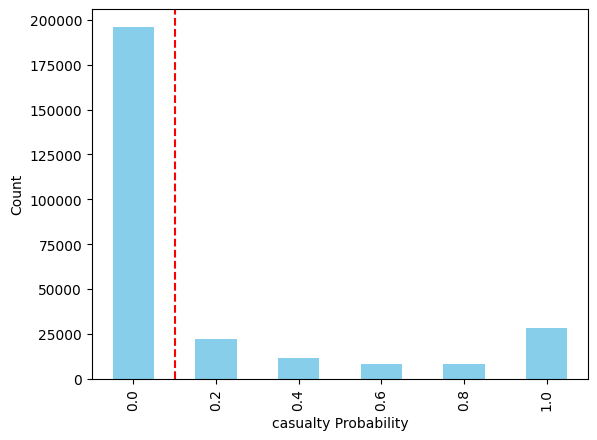

In [15]:
print(f"Percent of tweets possibly talking about {LABEL}: {round(100 * len(df[df[LABEL] > CLASSIFICATION_THRESHOLD]) / len(df), 2)}%")


counts = df[LABEL].round(2).value_counts().sort_index()
counts.plot(kind='bar', color='skyblue')
plt.axvline(x=CLASSIFICATION_THRESHOLD*5, color='red', linestyle='--')
plt.xlabel(f'{LABEL} Probability')
plt.ylabel('Count')
plt.show()

In [16]:
min_date = df.ts.min().date()
max_date = df.ts.max().date()
print(f"Batch of tweets about Ukraine's conflict uploaded from {min_date} to {max_date}")

Batch of tweets about Ukraine's conflict uploaded from 2022-02-22 to 2022-03-07


Average number of tweets per day: 19643.0 tweets


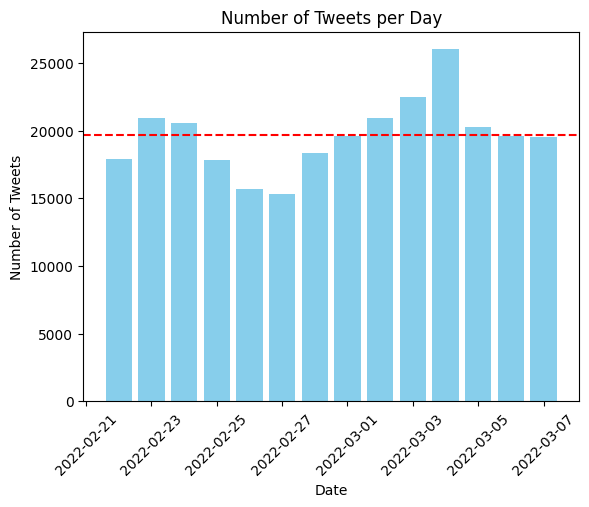

In [17]:
tweets_per_day = df["ts"].dt.date.value_counts().sort_index()
# Plotting the histogram
mean = round(sum(tweets_per_day.values) / len(tweets_per_day.values), 0)
print(f"Average number of tweets per day: {mean} tweets")

plt.bar(tweets_per_day.index, tweets_per_day.values, color='skyblue')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets per Day')
plt.axhline(y=mean, color='red', linestyle='--')
plt.xticks(rotation=45)
plt.show()

## Embedding tweets

In [18]:
# Returns the same df but with an additional column "embedding" of the (clean) tweet
def embed_df(df):

    embedded_tweets = EMBEDDING_MODEL.encode(df["text_clean"])

    df["embedding"] = embedded_tweets

    return df


# Returns embedded text
def embed_text(txt):

    return EMBEDDING_MODEL.encode(txt)

In [19]:
if EXECUTE_EMBEDDING:
  df = embed_df(df)

## Building the model

In [26]:
# Metrics to check during model training

# Recall: ability to identify all relevant instances (TP / TP + FN)
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Precision: ability to distinguish relevant instances from others (TP / TP + FP)
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# F1: mean of precision and recall (2*precision*recall / precision+recall)
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
def create_model():

  model = tf.keras.Sequential([
      tf.keras.Input(shape=(EMBEDDING_DIMENSION,), dtype="float32"),
      tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid),
  ])
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                metrics = [tf.keras.metrics.BinaryAccuracy(threshold=DECISION_THRESHOLD), recall_m, precision_m, f1_m])

  # callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10).
  # Get only the best model out of every epoch
  callback = tf.keras.callbacks.ModelCheckpoint(monitor='val_accuracy', save_best_only=True, mode='max', verbose=0, patience=10, filepath='prova.h5')

  return model, callback


model, _ = create_model()

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                24640     
                                                                 
 batch_normalization_4 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 8)                 520       
                                                                 
 batch_normalization_5 (Bat  (None, 8)                 32        
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 8)                

In [22]:
def save_model(model, title="prova",  metrics={}, path="/content/drive/MyDrive/Uni/Terzo anno/Progetto di Ingegneria Informatica/code/models/"):
  model.save(path+title+".h5")

  with h5py.File(path+title+".h5", 'a') as f:

    file_parameters = f.create_group('parameters')

    params = {"AL_METHOD":AL_METHOD,
              "AL_EFFICIENCY":AL_EFFICIENCY,
              "BUDGET":BUDGET,
              "TIMEFRAME":TIMEFRAME,
              "LEARNING_RATE":LEARNING_RATE,
              "DECISION_THRESHOLD":DECISION_THRESHOLD,
              "CLASSIFICATION_THRESHOLD":CLASSIFICATION_THRESHOLD,}

    # Store additional parameters
    for i, j in params.items():
      file_parameters.create_dataset(i, data=j)

    if metrics != {}:
      file_metrics = f.create_group('metrics')
      for i, j in metrics.items():
        file_metrics.create_dataset(i, data=j)




## Active Learning Methods

In [23]:
# Core Set: Farthest First Traversal (Approximated version)
def cs_farthest_first_selection(df, labelled, budget, label_column):
  df = df.reset_index(drop=True)

  points = df["embedding"].tolist()

  distances = euclidean_distances(points, points)

  while budget > 0:

    chosen = random.randint(0, len(df) - 1)

    curr = time.time()

    furthest = 0
    furthest_dist = 0

    # Searching for the element furthest away from the currently chosen one
    for i in range(len(df)):


      total_distance = distances[chosen, i]

      if furthest_dist < total_distance:
        # Avoiding elements already labelled
        if df.iloc[i]["embedding"] in list(labelled.keys()):
          continue
        furthest = i
        furthest_dist = total_distance


    labelled[df.iloc[furthest]["embedding"]] = classify(df.iloc[furthest][LABEL])

    budget -= 1

  del distances
  return labelled


In [24]:
# Core Set: Minimax (Correct version)
def cs_minimax_selection(df, labelled, budget, label_column):
  df = df.reset_index(drop=True)

  start = time.time()
  start_budget = budget

  points = df["embedding"].tolist()

  if len(labelled) == 0:
      labelled = {df.iloc[0]["embedding"]:df.iloc[0][LABEL]}

  distances = euclidean_distances(np.array(list(labelled.keys())), points)

  min_values = distances.min(axis=0)

  distances = euclidean_distances(points, points)


  while budget > 0:
    # Get argmax of minimum distances
    argmax = min_values.argmax()

    labelled[df.iloc[argmax]["embedding"]] = classify(df.iloc[argmax][LABEL])

    min_values = np.array([min(min_values[i], distances[argmax][i]) for i in range(len(min_values))])

    budget -= 1

  return labelled

In [25]:
# Good old random selection
def random_selection(curr, labelled:dict, budget:int, label_column:str):

  curr = curr.sample(budget)
  for i, label in zip(curr['embedding'], curr[label_column]):
    labelled[i] = classify(label)

  return labelled


In [26]:
al_methods = {"minimax":cs_minimax_selection,
              "farthest_first":cs_farthest_first_selection,
              "random":random_selection}

In [27]:
# Testing if Core Set Farthest First selection works
def check_label_position(df, labels, show_label=False):

  test = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=4).fit_transform(np.array(list(df["embedding"])))
  test = pd.DataFrame(test, columns = ["0_", "1_"])

  test["selected"] = [1 if i in labels.keys() else 0 for i in df["embedding"]]
  test[LABEL] = [i for i in df[LABEL]]
  test_labelled = test[test["selected"] == 1]

  plt.scatter(test["0_"], test["1_"], marker="x", c="black")
  if show_label:
    false_labels = test_labelled[test_labelled[LABEL] == 0]
    plt.scatter(false_labels["0_"], false_labels["1_"], marker="x", c="red")
    true_labels = test_labelled[test_labelled[LABEL] == 1]
    plt.scatter(true_labels["0_"], true_labels["1_"], marker="x", c="green")

  else:
    plt.scatter(test_labelled["0_"], test_labelled["1_"], marker="x", c="cyan")

  plt.show()


In [28]:
if CHECK_POSITION:
  curr = df[df.ts.dt.date == min_date]

  for method in al_methods.keys():
    labelled_elements = al_methods[method](curr, {}, BUDGET, LABEL)
    print(f"{method} selection")
    check_label_position(curr, labelled_elements, show_label=True)


In [29]:
def get_network_sets(x, y, next):

  # Splitting data into training, validation and test set
  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=TRAIN_RATIO, random_state=SEED)
  x_test, y_test = next['embedding'], next[LABEL]

  # Changing format to correctly use in neural network
  x_train = np.array([np.array(val) for val in x_train])
  y_train = np.array([np.array(val) for val in y_train])
  x_test = np.array([np.array(val) for val in x_test])
  y_test = np.array([np.array(val) for val in y_test])
  x_val = np.array([np.array(val) for val in x_val])
  y_val = np.array([np.array(val) for val in y_val])

  x_train = tf.cast(x_train , dtype=tf.float32)
  y_train = tf.cast(y_train , dtype=tf.float32)
  x_test = tf.cast(x_train , dtype=tf.float32)
  y_test = tf.cast(y_train , dtype=tf.float32)
  x_val = tf.cast(x_train , dtype=tf.float32)
  y_val = tf.cast(y_train , dtype=tf.float32)

  return x_train, y_train, x_test, y_test, x_val, y_val

In [30]:
def plot_results(history, train=True, validation=True, precision=False, recall=False, f1=False):

  legend = []
  if train:
    plt.plot(history.history['binary_accuracy'])
    legend.append("train")
  if validation:
    plt.plot(history.history['val_binary_accuracy'])
    legend.append("validation")
  if precision:
    plt.plot(history.history['precision_m'])
    legend.append("validation")
  if recall:
    plt.plot(history.history['recall_m'])
    legend.append("recall")
  if f1:
    plt.plot(history.history['f1_m'])
    legend.append("f1")

  plt.title(f'model accuracy')
  plt.ylabel('performance metrics')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')
  plt.show()

Epoch 1/16


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1700/1719 [============================>.] - ETA: 0s - loss: 0.2200 - binary_accuracy: 0.6493 - recall_m: 0.7279 - precision_m: 0.3431 - f1_m: 0.4468

1719/1719 [==============================] - 10s 4ms/step - loss: 0.2199 - binary_accuracy: 0.6499 - recall_m: 0.7285 - precision_m: 0.3437 - f1_m: 0.4474 - val_loss: 0.4321 - val_binary_accuracy: 0.6843 - val_recall_m: 0.7739 - val_precision_m: 0.3796 - val_f1_m: 0.4947
Epoch 2/16
1713/1719 [============================>.] - ETA: 0s - loss: 0.1997 - binary_accuracy: 0.7046 - recall_m: 0.7290 - precision_m: 0.4123 - f1_m: 0.5078

1719/1719 [==============================] - 8s 5ms/step - loss: 0.1997 - binary_accuracy: 0.7047 - recall_m: 0.7290 - precision_m: 0.4125 - f1_m: 0.5080 - val_loss: 0.3245 - val_binary_accuracy: 0.7536 - val_recall_m: 0.6950 - val_precision_m: 0.5042 - val_f1_m: 0.5669
Epoch 3/16
1708/1719 [============================>.] - ETA: 0s - loss: 0.1927 - binary_accuracy: 0.7188 - recall_m: 0.7446 - precision_m: 0.4409 - f1_m: 0.5327

1719/1719 [==============================] - 10s 6ms/step - loss: 0.1927 - binary_accuracy: 0.7186 - recall_m: 0.7444 - precision_m: 0.4407 - f1_m: 0.5325 - val_loss: 0.3829 - val_binary_accuracy: 0.7142 - val_recall_m: 0.7738 - val_precision_m: 0.4250 - val_f1_m: 0.5325
Epoch 4/16
1716/1719 [============================>.] - ETA: 0s - loss: 0.1903 - binary_accuracy: 0.7226 - recall_m: 0.7402 - precision_m: 0.4464 - f1_m: 0.5359

1719/1719 [==============================] - 7s 4ms/step - loss: 0.1903 - binary_accuracy: 0.7227 - recall_m: 0.7402 - precision_m: 0.4465 - f1_m: 0.5360 - val_loss: 0.3197 - val_binary_accuracy: 0.7559 - val_recall_m: 0.7159 - val_precision_m: 0.5168 - val_f1_m: 0.5823
Epoch 5/16
1718/1719 [============================>.] - ETA: 0s - loss: 0.1886 - binary_accuracy: 0.7235 - recall_m: 0.7419 - precision_m: 0.4454 - f1_m: 0.5353

1719/1719 [==============================] - 9s 5ms/step - loss: 0.1886 - binary_accuracy: 0.7236 - recall_m: 0.7419 - precision_m: 0.4454 - f1_m: 0.5353 - val_loss: 0.3415 - val_binary_accuracy: 0.7380 - val_recall_m: 0.7466 - val_precision_m: 0.4588 - val_f1_m: 0.5524
Epoch 6/16
1707/1719 [============================>.] - ETA: 0s - loss: 0.1854 - binary_accuracy: 0.7259 - recall_m: 0.7455 - precision_m: 0.4506 - f1_m: 0.5407

1719/1719 [==============================] - 7s 4ms/step - loss: 0.1855 - binary_accuracy: 0.7259 - recall_m: 0.7454 - precision_m: 0.4505 - f1_m: 0.5406 - val_loss: 0.3472 - val_binary_accuracy: 0.7343 - val_recall_m: 0.7581 - val_precision_m: 0.4531 - val_f1_m: 0.5513
Epoch 7/16
1702/1719 [============================>.] - ETA: 0s - loss: 0.1830 - binary_accuracy: 0.7277 - recall_m: 0.7447 - precision_m: 0.4524 - f1_m: 0.5426

1719/1719 [==============================] - 8s 5ms/step - loss: 0.1829 - binary_accuracy: 0.7275 - recall_m: 0.7454 - precision_m: 0.4521 - f1_m: 0.5425 - val_loss: 0.3417 - val_binary_accuracy: 0.7372 - val_recall_m: 0.7577 - val_precision_m: 0.4556 - val_f1_m: 0.5535
Epoch 8/16
1704/1719 [============================>.] - ETA: 0s - loss: 0.1816 - binary_accuracy: 0.7289 - recall_m: 0.7466 - precision_m: 0.4536 - f1_m: 0.5428

1719/1719 [==============================] - 8s 5ms/step - loss: 0.1816 - binary_accuracy: 0.7286 - recall_m: 0.7467 - precision_m: 0.4534 - f1_m: 0.5426 - val_loss: 0.2988 - val_binary_accuracy: 0.7609 - val_recall_m: 0.7274 - val_precision_m: 0.5235 - val_f1_m: 0.5925
Epoch 9/16
1702/1719 [============================>.] - ETA: 0s - loss: 0.1799 - binary_accuracy: 0.7314 - recall_m: 0.7530 - precision_m: 0.4594 - f1_m: 0.5497

1719/1719 [==============================] - 10s 6ms/step - loss: 0.1798 - binary_accuracy: 0.7315 - recall_m: 0.7534 - precision_m: 0.4597 - f1_m: 0.5500 - val_loss: 0.3185 - val_binary_accuracy: 0.7499 - val_recall_m: 0.7509 - val_precision_m: 0.4931 - val_f1_m: 0.5788
Epoch 10/16
1712/1719 [============================>.] - ETA: 0s - loss: 0.1789 - binary_accuracy: 0.7330 - recall_m: 0.7527 - precision_m: 0.4637 - f1_m: 0.5534

1719/1719 [==============================] - 9s 5ms/step - loss: 0.1788 - binary_accuracy: 0.7330 - recall_m: 0.7531 - precision_m: 0.4639 - f1_m: 0.5537 - val_loss: 0.3486 - val_binary_accuracy: 0.7326 - val_recall_m: 0.7775 - val_precision_m: 0.4470 - val_f1_m: 0.5524
Epoch 11/16
1718/1719 [============================>.] - ETA: 0s - loss: 0.1765 - binary_accuracy: 0.7331 - recall_m: 0.7550 - precision_m: 0.4601 - f1_m: 0.5498

1719/1719 [==============================] - 10s 6ms/step - loss: 0.1765 - binary_accuracy: 0.7330 - recall_m: 0.7548 - precision_m: 0.4599 - f1_m: 0.5496 - val_loss: 0.2922 - val_binary_accuracy: 0.7644 - val_recall_m: 0.7346 - val_precision_m: 0.5292 - val_f1_m: 0.5988
Epoch 12/16
1707/1719 [============================>.] - ETA: 0s - loss: 0.1760 - binary_accuracy: 0.7352 - recall_m: 0.7548 - precision_m: 0.4669 - f1_m: 0.5557

1719/1719 [==============================] - 7s 4ms/step - loss: 0.1761 - binary_accuracy: 0.7350 - recall_m: 0.7555 - precision_m: 0.4668 - f1_m: 0.5558 - val_loss: 0.3185 - val_binary_accuracy: 0.7478 - val_recall_m: 0.7677 - val_precision_m: 0.4835 - val_f1_m: 0.5773
Epoch 13/16
1711/1719 [============================>.] - ETA: 0s - loss: 0.1748 - binary_accuracy: 0.7355 - recall_m: 0.7595 - precision_m: 0.4679 - f1_m: 0.5572

1719/1719 [==============================] - 12s 7ms/step - loss: 0.1746 - binary_accuracy: 0.7354 - recall_m: 0.7599 - precision_m: 0.4679 - f1_m: 0.5574 - val_loss: 0.3068 - val_binary_accuracy: 0.7535 - val_recall_m: 0.7677 - val_precision_m: 0.4988 - val_f1_m: 0.5885
Epoch 14/16
1710/1719 [============================>.] - ETA: 0s - loss: 0.1730 - binary_accuracy: 0.7354 - recall_m: 0.7540 - precision_m: 0.4662 - f1_m: 0.5556

1719/1719 [==============================] - 8s 5ms/step - loss: 0.1729 - binary_accuracy: 0.7357 - recall_m: 0.7545 - precision_m: 0.4664 - f1_m: 0.5558 - val_loss: 0.3257 - val_binary_accuracy: 0.7432 - val_recall_m: 0.7741 - val_precision_m: 0.4713 - val_f1_m: 0.5705
Epoch 15/16
1714/1719 [============================>.] - ETA: 0s - loss: 0.1722 - binary_accuracy: 0.7356 - recall_m: 0.7622 - precision_m: 0.4692 - f1_m: 0.5581

1719/1719 [==============================] - 7s 4ms/step - loss: 0.1722 - binary_accuracy: 0.7355 - recall_m: 0.7624 - precision_m: 0.4694 - f1_m: 0.5583 - val_loss: 0.3162 - val_binary_accuracy: 0.7458 - val_recall_m: 0.7761 - val_precision_m: 0.4746 - val_f1_m: 0.5736
Epoch 16/16
1718/1719 [============================>.] - ETA: 0s - loss: 0.1702 - binary_accuracy: 0.7374 - recall_m: 0.7597 - precision_m: 0.4733 - f1_m: 0.5619

1719/1719 [==============================] - 3s 2ms/step - loss: 0.2946 - binary_accuracy: 0.7586 - recall_m: 0.7616 - precision_m: 0.5092 - f1_m: 0.5943
Train Accuracy
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2946 - binary_accuracy: 0.7586 - recall_m: 0.7616 - precision_m: 0.5092 - f1_m: 0.5943
Test Accuracy
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2946 - binary_accuracy: 0.7586 - recall_m: 0.7616 - precision_m: 0.5092 - f1_m: 0.5943


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


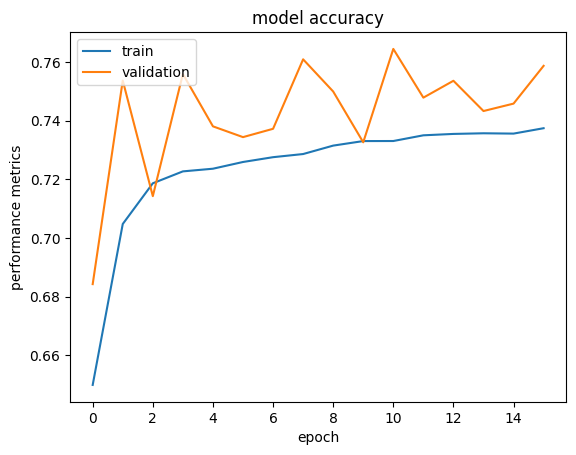

In [31]:
if TRAIN_ALL_DATA:

  curr = df[df.ts.dt.date != max_date]
  next = df[df.ts.dt.date == max_date]

  x, y = df["embedding"], df[LABEL]

  # Getting correct sets
  x_train, y_train, x_test, y_test, x_val, y_val = get_network_sets(x, y, df)

  # Creating model
  model, callback = create_model()

  # Calculating weights for better cnn performance
  class_weights = compute_class_weight(class_weight='balanced', classes=list(set(y)), y=y)
  class_weights = {class_index: weight for class_index, weight in enumerate(class_weights)}

  # Training model
  history = model.fit(x_train, y_train,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      verbose=1,
                      validation_data=([x_val, y_val]),
                      callbacks=callback,
                      class_weight=class_weights)

  # Evaluating Model
  model.evaluate(x_test, y_test, verbose=1)

  print('Train Accuracy')
  model.evaluate(x_train, y_train)
  print('Test Accuracy')
  model.evaluate(x_test, y_test)

  save_model(model, title="best_result")

  plot_results(history)

Epoch 1/16


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/7 [===>..........................] - ETA: 10s - loss: 0.4631 - binary_accuracy: 0.5625 - recall_m: 1.0000 - precision_m: 0.0667 - f1_m: 0.1250

7/7 [==============================] - 2s 64ms/step - loss: 0.8786 - binary_accuracy: 0.5250 - recall_m: 0.2619 - precision_m: 0.0298 - f1_m: 0.0526 - val_loss: 0.6822 - val_binary_accuracy: 0.6800 - val_recall_m: 0.1667 - val_precision_m: 0.0306 - val_f1_m: 0.0515
Epoch 2/16
1/7 [===>..........................] - ETA: 0s - loss: 1.1826 - binary_accuracy: 0.5000 - recall_m: 0.5000 - precision_m: 0.0625 - f1_m: 0.1111

7/7 [==============================] - 0s 12ms/step - loss: 0.7252 - binary_accuracy: 0.5050 - recall_m: 0.3333 - precision_m: 0.0382 - f1_m: 0.0668 - val_loss: 0.6764 - val_binary_accuracy: 0.7800 - val_recall_m: 0.4048 - val_precision_m: 0.1095 - val_f1_m: 0.1593
Epoch 3/16
1/7 [===>..........................] - ETA: 0s - loss: 0.6923 - binary_accuracy: 0.5000 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

7/7 [==============================] - 0s 12ms/step - loss: 0.5739 - binary_accuracy: 0.5500 - recall_m: 0.3810 - precision_m: 0.0578 - f1_m: 0.0976 - val_loss: 0.6680 - val_binary_accuracy: 0.8500 - val_recall_m: 0.5000 - val_precision_m: 0.1683 - val_f1_m: 0.2374
Epoch 4/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4273 - binary_accuracy: 0.5625 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

7/7 [==============================] - 0s 13ms/step - loss: 0.4844 - binary_accuracy: 0.5900 - recall_m: 0.5238 - precision_m: 0.0803 - f1_m: 0.1370 - val_loss: 0.6587 - val_binary_accuracy: 0.9300 - val_recall_m: 0.5714 - val_precision_m: 0.2684 - val_f1_m: 0.3510
Epoch 5/16
1/7 [===>..........................] - ETA: 0s - loss: 0.6928 - binary_accuracy: 0.6250 - recall_m: 0.5000 - precision_m: 0.0833 - f1_m: 0.1429

7/7 [==============================] - 0s 11ms/step - loss: 0.5584 - binary_accuracy: 0.5300 - recall_m: 0.5714 - precision_m: 0.0644 - f1_m: 0.1144 - val_loss: 0.6471 - val_binary_accuracy: 0.9700 - val_recall_m: 0.4524 - val_precision_m: 0.5238 - val_f1_m: 0.4762
Epoch 6/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4731 - binary_accuracy: 0.4688 - recall_m: 1.0000 - precision_m: 0.0556 - f1_m: 0.1053

7/7 [==============================] - 0s 11ms/step - loss: 0.4599 - binary_accuracy: 0.6050 - recall_m: 0.6667 - precision_m: 0.0877 - f1_m: 0.1517 - val_loss: 0.6386 - val_binary_accuracy: 0.9850 - val_recall_m: 0.4524 - val_precision_m: 0.5714 - val_f1_m: 0.4952
Epoch 7/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3364 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.2000 - f1_m: 0.3333

7/7 [==============================] - 0s 11ms/step - loss: 0.4308 - binary_accuracy: 0.6250 - recall_m: 0.4286 - precision_m: 0.0898 - f1_m: 0.1468 - val_loss: 0.6272 - val_binary_accuracy: 0.9900 - val_recall_m: 0.4524 - val_precision_m: 0.5714 - val_f1_m: 0.4952
Epoch 8/16
1/7 [===>..........................] - ETA: 0s - loss: 0.2550 - binary_accuracy: 0.7812 - recall_m: 1.0000 - precision_m: 0.3000 - f1_m: 0.4615

7/7 [==============================] - 0s 13ms/step - loss: 0.3958 - binary_accuracy: 0.5850 - recall_m: 0.7143 - precision_m: 0.0990 - f1_m: 0.1672 - val_loss: 0.6140 - val_binary_accuracy: 0.9900 - val_recall_m: 0.4524 - val_precision_m: 0.5714 - val_f1_m: 0.4952
Epoch 9/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4425 - binary_accuracy: 0.4688 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

7/7 [==============================] - 0s 12ms/step - loss: 0.3996 - binary_accuracy: 0.6250 - recall_m: 0.7143 - precision_m: 0.1070 - f1_m: 0.1757 - val_loss: 0.6028 - val_binary_accuracy: 0.9850 - val_recall_m: 0.3095 - val_precision_m: 0.4286 - val_f1_m: 0.3524
Epoch 10/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3862 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.0769 - f1_m: 0.1429

7/7 [==============================] - 0s 10ms/step - loss: 0.4247 - binary_accuracy: 0.6500 - recall_m: 0.8571 - precision_m: 0.1005 - f1_m: 0.1776 - val_loss: 0.5889 - val_binary_accuracy: 0.9800 - val_recall_m: 0.2619 - val_precision_m: 0.4286 - val_f1_m: 0.3095
Epoch 11/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3319 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.1538 - f1_m: 0.2667

7/7 [==============================] - 0s 10ms/step - loss: 0.3927 - binary_accuracy: 0.6150 - recall_m: 0.7143 - precision_m: 0.0979 - f1_m: 0.1683 - val_loss: 0.5775 - val_binary_accuracy: 0.9750 - val_recall_m: 0.2143 - val_precision_m: 0.2857 - val_f1_m: 0.2381
Epoch 12/16
1/7 [===>..........................] - ETA: 0s - loss: 0.2930 - binary_accuracy: 0.7500 - recall_m: 1.0000 - precision_m: 0.2000 - f1_m: 0.3333

7/7 [==============================] - 0s 10ms/step - loss: 0.3834 - binary_accuracy: 0.6450 - recall_m: 0.7143 - precision_m: 0.0934 - f1_m: 0.1633 - val_loss: 0.5668 - val_binary_accuracy: 0.9750 - val_recall_m: 0.2143 - val_precision_m: 0.2857 - val_f1_m: 0.2381
Epoch 13/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5027 - binary_accuracy: 0.7188 - recall_m: 1.0000 - precision_m: 0.2500 - f1_m: 0.4000

7/7 [==============================] - 0s 11ms/step - loss: 0.4065 - binary_accuracy: 0.6350 - recall_m: 0.6429 - precision_m: 0.1174 - f1_m: 0.1952 - val_loss: 0.5587 - val_binary_accuracy: 0.9750 - val_recall_m: 0.2143 - val_precision_m: 0.2857 - val_f1_m: 0.2381
Epoch 14/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5471 - binary_accuracy: 0.6562 - recall_m: 0.6667 - precision_m: 0.1667 - f1_m: 0.2667

7/7 [==============================] - 0s 10ms/step - loss: 0.3717 - binary_accuracy: 0.6800 - recall_m: 0.6667 - precision_m: 0.2324 - f1_m: 0.2928 - val_loss: 0.5488 - val_binary_accuracy: 0.9750 - val_recall_m: 0.2143 - val_precision_m: 0.2857 - val_f1_m: 0.2381
Epoch 15/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3945 - binary_accuracy: 0.6562 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

7/7 [==============================] - 0s 10ms/step - loss: 0.3517 - binary_accuracy: 0.7100 - recall_m: 0.5714 - precision_m: 0.1175 - f1_m: 0.1908 - val_loss: 0.5389 - val_binary_accuracy: 0.9700 - val_recall_m: 0.1667 - val_precision_m: 0.2857 - val_f1_m: 0.2095
Epoch 16/16
1/7 [===>..........................] - ETA: 0s - loss: 0.2701 - binary_accuracy: 0.7500 - recall_m: 1.0000 - precision_m: 0.1111 - f1_m: 0.2000

7/7 [==============================] - 0s 4ms/step - loss: 0.5296 - binary_accuracy: 0.9700 - recall_m: 0.1667 - precision_m: 0.2857 - f1_m: 0.2095        
Train Accuracy
7/7 [==============================] - 0s 3ms/step - loss: 0.5296 - binary_accuracy: 0.9700 - recall_m: 0.1667 - precision_m: 0.2857 - f1_m: 0.2095        
Test Accuracy
7/7 [==============================] - 0s 3ms/step - loss: 0.5296 - binary_accuracy: 0.9700 - recall_m: 0.1667 - precision_m: 0.2857 - f1_m: 0.2095        


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Current date: 2022-02-22 (0/12)


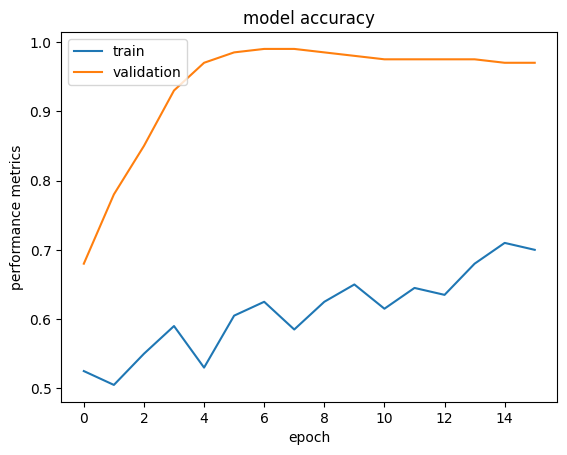

Epoch 1/16


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/7 [===>..........................] - ETA: 10s - loss: 0.9103 - binary_accuracy: 0.5312 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

7/7 [==============================] - 2s 64ms/step - loss: 0.9088 - binary_accuracy: 0.4900 - recall_m: 0.4048 - precision_m: 0.0571 - f1_m: 0.0972 - val_loss: 0.6849 - val_binary_accuracy: 0.6750 - val_recall_m: 0.7500 - val_precision_m: 0.1425 - val_f1_m: 0.2339
Epoch 2/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5721 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.1429 - f1_m: 0.2500

7/7 [==============================] - 0s 11ms/step - loss: 0.6522 - binary_accuracy: 0.5900 - recall_m: 0.6857 - precision_m: 0.1175 - f1_m: 0.1969 - val_loss: 0.6813 - val_binary_accuracy: 0.7300 - val_recall_m: 0.8452 - val_precision_m: 0.2333 - val_f1_m: 0.3415
Epoch 3/16
1/7 [===>..........................] - ETA: 0s - loss: 0.7266 - binary_accuracy: 0.5938 - recall_m: 0.8333 - precision_m: 0.2941 - f1_m: 0.4348

7/7 [==============================] - 0s 10ms/step - loss: 0.5785 - binary_accuracy: 0.5450 - recall_m: 0.7619 - precision_m: 0.1136 - f1_m: 0.1887 - val_loss: 0.6777 - val_binary_accuracy: 0.7700 - val_recall_m: 0.7976 - val_precision_m: 0.2295 - val_f1_m: 0.3339
Epoch 4/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5972 - binary_accuracy: 0.5625 - recall_m: 1.0000 - precision_m: 0.1765 - f1_m: 0.3000

7/7 [==============================] - 0s 11ms/step - loss: 0.5744 - binary_accuracy: 0.5650 - recall_m: 0.6429 - precision_m: 0.1186 - f1_m: 0.1975 - val_loss: 0.6677 - val_binary_accuracy: 0.8700 - val_recall_m: 0.8452 - val_precision_m: 0.3857 - val_f1_m: 0.4857
Epoch 5/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4894 - binary_accuracy: 0.5625 - recall_m: 1.0000 - precision_m: 0.0667 - f1_m: 0.1250

7/7 [==============================] - 0s 12ms/step - loss: 0.5102 - binary_accuracy: 0.5900 - recall_m: 0.8286 - precision_m: 0.1266 - f1_m: 0.2091 - val_loss: 0.6568 - val_binary_accuracy: 0.9550 - val_recall_m: 0.8452 - val_precision_m: 0.7476 - val_f1_m: 0.7565
Epoch 6/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5384 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.2000 - f1_m: 0.3333

7/7 [==============================] - 0s 13ms/step - loss: 0.5325 - binary_accuracy: 0.5700 - recall_m: 0.8214 - precision_m: 0.1684 - f1_m: 0.2735 - val_loss: 0.6473 - val_binary_accuracy: 0.9850 - val_recall_m: 0.8452 - val_precision_m: 1.0000 - val_f1_m: 0.9034
Epoch 7/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3651 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.1538 - f1_m: 0.2667

7/7 [==============================] - 0s 12ms/step - loss: 0.4723 - binary_accuracy: 0.6100 - recall_m: 0.8571 - precision_m: 0.2221 - f1_m: 0.3262 - val_loss: 0.6386 - val_binary_accuracy: 0.9800 - val_recall_m: 0.7024 - val_precision_m: 0.8571 - val_f1_m: 0.7605
Epoch 8/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4532 - binary_accuracy: 0.4688 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

7/7 [==============================] - 0s 12ms/step - loss: 0.4132 - binary_accuracy: 0.6550 - recall_m: 0.8571 - precision_m: 0.2964 - f1_m: 0.3883 - val_loss: 0.6296 - val_binary_accuracy: 0.9850 - val_recall_m: 0.7500 - val_precision_m: 0.8571 - val_f1_m: 0.7891
Epoch 9/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5356 - binary_accuracy: 0.5312 - recall_m: 1.0000 - precision_m: 0.1176 - f1_m: 0.2105

7/7 [==============================] - 0s 12ms/step - loss: 0.4765 - binary_accuracy: 0.6000 - recall_m: 0.8214 - precision_m: 0.1401 - f1_m: 0.2321 - val_loss: 0.6199 - val_binary_accuracy: 0.9850 - val_recall_m: 0.7500 - val_precision_m: 0.8571 - val_f1_m: 0.7891
Epoch 10/16
1/7 [===>..........................] - ETA: 0s - loss: 0.6265 - binary_accuracy: 0.6875 - recall_m: 0.7500 - precision_m: 0.2500 - f1_m: 0.3750

7/7 [==============================] - 0s 12ms/step - loss: 0.4289 - binary_accuracy: 0.6300 - recall_m: 0.9643 - precision_m: 0.2158 - f1_m: 0.3316 - val_loss: 0.6119 - val_binary_accuracy: 0.9850 - val_recall_m: 0.7500 - val_precision_m: 0.8571 - val_f1_m: 0.7891
Epoch 11/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3330 - binary_accuracy: 0.6875 - recall_m: 1.0000 - precision_m: 0.1667 - f1_m: 0.2857

7/7 [==============================] - 0s 14ms/step - loss: 0.4805 - binary_accuracy: 0.6050 - recall_m: 0.8095 - precision_m: 0.1760 - f1_m: 0.2805 - val_loss: 0.6000 - val_binary_accuracy: 0.9850 - val_recall_m: 0.7500 - val_precision_m: 0.8571 - val_f1_m: 0.7891
Epoch 12/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4130 - binary_accuracy: 0.5938 - recall_m: 1.0000 - precision_m: 0.1875 - f1_m: 0.3158

7/7 [==============================] - 0s 11ms/step - loss: 0.4045 - binary_accuracy: 0.6550 - recall_m: 0.9643 - precision_m: 0.1793 - f1_m: 0.2944 - val_loss: 0.5899 - val_binary_accuracy: 0.9800 - val_recall_m: 0.7024 - val_precision_m: 0.8571 - val_f1_m: 0.7605
Epoch 13/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3620 - binary_accuracy: 0.7500 - recall_m: 1.0000 - precision_m: 0.2727 - f1_m: 0.4286

7/7 [==============================] - 0s 12ms/step - loss: 0.3698 - binary_accuracy: 0.6800 - recall_m: 0.7143 - precision_m: 0.1745 - f1_m: 0.2687 - val_loss: 0.5797 - val_binary_accuracy: 0.9700 - val_recall_m: 0.6190 - val_precision_m: 0.8571 - val_f1_m: 0.6905
Epoch 14/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3959 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.1429 - f1_m: 0.2500

7/7 [==============================] - 0s 11ms/step - loss: 0.3237 - binary_accuracy: 0.6950 - recall_m: 0.8571 - precision_m: 0.2404 - f1_m: 0.3594 - val_loss: 0.5687 - val_binary_accuracy: 0.9700 - val_recall_m: 0.6190 - val_precision_m: 0.8571 - val_f1_m: 0.6905
Epoch 15/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4210 - binary_accuracy: 0.5625 - recall_m: 1.0000 - precision_m: 0.0667 - f1_m: 0.1250

7/7 [==============================] - 0s 11ms/step - loss: 0.3522 - binary_accuracy: 0.6950 - recall_m: 0.7143 - precision_m: 0.1944 - f1_m: 0.2813 - val_loss: 0.5579 - val_binary_accuracy: 0.9700 - val_recall_m: 0.6190 - val_precision_m: 0.8571 - val_f1_m: 0.6905
Epoch 16/16
1/7 [===>..........................] - ETA: 0s - loss: 0.2590 - binary_accuracy: 0.7812 - recall_m: 1.0000 - precision_m: 0.3000 - f1_m: 0.4615

7/7 [==============================] - 0s 3ms/step - loss: 0.5451 - binary_accuracy: 0.9700 - recall_m: 0.6190 - precision_m: 0.8571 - f1_m: 0.6905
Train Accuracy
7/7 [==============================] - 0s 3ms/step - loss: 0.5451 - binary_accuracy: 0.9700 - recall_m: 0.6190 - precision_m: 0.8571 - f1_m: 0.6905
Test Accuracy
7/7 [==============================] - 0s 3ms/step - loss: 0.5451 - binary_accuracy: 0.9700 - recall_m: 0.6190 - precision_m: 0.8571 - f1_m: 0.6905


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Current date: 2022-02-23 (1/12)


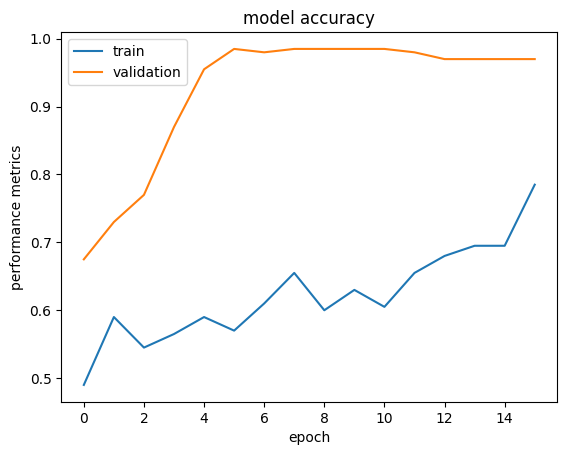

Epoch 1/16


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/7 [===>..........................] - ETA: 29s - loss: 1.0149 - binary_accuracy: 0.5625 - recall_m: 0.4000 - precision_m: 0.1538 - f1_m: 0.2222

7/7 [==============================] - 6s 155ms/step - loss: 1.0224 - binary_accuracy: 0.4550 - recall_m: 0.3369 - precision_m: 0.0903 - f1_m: 0.1376 - val_loss: 0.6966 - val_binary_accuracy: 0.4550 - val_recall_m: 0.7762 - val_precision_m: 0.1542 - val_f1_m: 0.2529
Epoch 2/16
1/7 [===>..........................] - ETA: 0s - loss: 0.7724 - binary_accuracy: 0.4062 - recall_m: 0.6667 - precision_m: 0.1000 - f1_m: 0.1739

7/7 [==============================] - 0s 23ms/step - loss: 0.7461 - binary_accuracy: 0.4700 - recall_m: 0.6048 - precision_m: 0.1344 - f1_m: 0.2144 - val_loss: 0.7107 - val_binary_accuracy: 0.2500 - val_recall_m: 0.8571 - val_precision_m: 0.1252 - val_f1_m: 0.2164
Epoch 3/16
5/7 [====================>.........] - ETA: 0s - loss: 0.6519 - binary_accuracy: 0.5125 - recall_m: 0.7667 - precision_m: 0.1540 - f1_m: 0.2463

7/7 [==============================] - 0s 38ms/step - loss: 0.6766 - binary_accuracy: 0.5100 - recall_m: 0.7762 - precision_m: 0.1695 - f1_m: 0.2704 - val_loss: 0.7193 - val_binary_accuracy: 0.1850 - val_recall_m: 0.8571 - val_precision_m: 0.1178 - val_f1_m: 0.2049
Epoch 4/16
7/7 [==============================] - ETA: 0s - loss: 0.6066 - binary_accuracy: 0.6000 - recall_m: 0.6929 - precision_m: 0.2703 - f1_m: 0.3665            

7/7 [==============================] - 0s 35ms/step - loss: 0.6066 - binary_accuracy: 0.6000 - recall_m: 0.6929 - precision_m: 0.2703 - f1_m: 0.3665 - val_loss: 0.7261 - val_binary_accuracy: 0.1700 - val_recall_m: 0.8571 - val_precision_m: 0.1164 - val_f1_m: 0.2027
Epoch 5/16
6/7 [========================>.....] - ETA: 0s - loss: 0.4787 - binary_accuracy: 0.5833 - recall_m: 1.0000 - precision_m: 0.2323 - f1_m: 0.3756

7/7 [==============================] - 0s 36ms/step - loss: 0.4877 - binary_accuracy: 0.5800 - recall_m: 1.0000 - precision_m: 0.2277 - f1_m: 0.3695 - val_loss: 0.7358 - val_binary_accuracy: 0.1500 - val_recall_m: 0.8571 - val_precision_m: 0.1138 - val_f1_m: 0.1987
Epoch 6/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4012 - binary_accuracy: 0.5938 - recall_m: 1.0000 - precision_m: 0.1875 - f1_m: 0.3158

7/7 [==============================] - 0s 20ms/step - loss: 0.4526 - binary_accuracy: 0.6450 - recall_m: 0.8571 - precision_m: 0.2351 - f1_m: 0.3594 - val_loss: 0.7405 - val_binary_accuracy: 0.1400 - val_recall_m: 0.8571 - val_precision_m: 0.1126 - val_f1_m: 0.1970
Epoch 7/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4508 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.2143 - f1_m: 0.3529

7/7 [==============================] - 0s 27ms/step - loss: 0.4857 - binary_accuracy: 0.6150 - recall_m: 0.9000 - precision_m: 0.2720 - f1_m: 0.4060 - val_loss: 0.7427 - val_binary_accuracy: 0.1350 - val_recall_m: 0.8571 - val_precision_m: 0.1119 - val_f1_m: 0.1959
Epoch 8/16
7/7 [==============================] - ETA: 0s - loss: 0.4372 - binary_accuracy: 0.6400 - recall_m: 1.0000 - precision_m: 0.2856 - f1_m: 0.4330

7/7 [==============================] - 0s 33ms/step - loss: 0.4372 - binary_accuracy: 0.6400 - recall_m: 1.0000 - precision_m: 0.2856 - f1_m: 0.4330 - val_loss: 0.7437 - val_binary_accuracy: 0.1350 - val_recall_m: 0.8571 - val_precision_m: 0.1119 - val_f1_m: 0.1959
Epoch 9/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4852 - binary_accuracy: 0.7812 - recall_m: 0.8750 - precision_m: 0.5385 - f1_m: 0.6667

7/7 [==============================] - 0s 26ms/step - loss: 0.4423 - binary_accuracy: 0.6350 - recall_m: 0.8393 - precision_m: 0.3610 - f1_m: 0.4583 - val_loss: 0.7476 - val_binary_accuracy: 0.1300 - val_recall_m: 0.8571 - val_precision_m: 0.1119 - val_f1_m: 0.1959
Epoch 10/16
5/7 [====================>.........] - ETA: 0s - loss: 0.4398 - binary_accuracy: 0.5938 - recall_m: 1.0000 - precision_m: 0.2062 - f1_m: 0.3262

7/7 [==============================] - 0s 32ms/step - loss: 0.4353 - binary_accuracy: 0.6100 - recall_m: 1.0000 - precision_m: 0.2418 - f1_m: 0.3735 - val_loss: 0.7488 - val_binary_accuracy: 0.1350 - val_recall_m: 0.8571 - val_precision_m: 0.1119 - val_f1_m: 0.1959
Epoch 11/16
7/7 [==============================] - ETA: 0s - loss: 0.3809 - binary_accuracy: 0.6950 - recall_m: 0.8571 - precision_m: 0.2671 - f1_m: 0.3968

7/7 [==============================] - 0s 36ms/step - loss: 0.3809 - binary_accuracy: 0.6950 - recall_m: 0.8571 - precision_m: 0.2671 - f1_m: 0.3968 - val_loss: 0.7450 - val_binary_accuracy: 0.1350 - val_recall_m: 0.8571 - val_precision_m: 0.1119 - val_f1_m: 0.1959
Epoch 12/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3547 - binary_accuracy: 0.6875 - recall_m: 1.0000 - precision_m: 0.1667 - f1_m: 0.2857

7/7 [==============================] - 0s 32ms/step - loss: 0.3560 - binary_accuracy: 0.6900 - recall_m: 1.0000 - precision_m: 0.2830 - f1_m: 0.4323 - val_loss: 0.7378 - val_binary_accuracy: 0.1400 - val_recall_m: 0.8571 - val_precision_m: 0.1126 - val_f1_m: 0.1970
Epoch 13/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3002 - binary_accuracy: 0.7812 - recall_m: 1.0000 - precision_m: 0.4167 - f1_m: 0.5882

7/7 [==============================] - 0s 26ms/step - loss: 0.3649 - binary_accuracy: 0.6850 - recall_m: 0.9286 - precision_m: 0.3116 - f1_m: 0.4384 - val_loss: 0.7305 - val_binary_accuracy: 0.1600 - val_recall_m: 0.8571 - val_precision_m: 0.1145 - val_f1_m: 0.1999
Epoch 14/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3648 - binary_accuracy: 0.7500 - recall_m: 1.0000 - precision_m: 0.4286 - f1_m: 0.6000

7/7 [==============================] - 0s 24ms/step - loss: 0.3375 - binary_accuracy: 0.7300 - recall_m: 0.8571 - precision_m: 0.2768 - f1_m: 0.4073 - val_loss: 0.7201 - val_binary_accuracy: 0.2000 - val_recall_m: 0.8571 - val_precision_m: 0.1196 - val_f1_m: 0.2079
Epoch 15/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4699 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.2000 - f1_m: 0.3333

7/7 [==============================] - 0s 25ms/step - loss: 0.3691 - binary_accuracy: 0.6950 - recall_m: 1.0000 - precision_m: 0.2892 - f1_m: 0.4319 - val_loss: 0.7120 - val_binary_accuracy: 0.2400 - val_recall_m: 0.8571 - val_precision_m: 0.1252 - val_f1_m: 0.2163
Epoch 16/16
5/7 [====================>.........] - ETA: 0s - loss: 0.3255 - binary_accuracy: 0.7750 - recall_m: 1.0000 - precision_m: 0.3737 - f1_m: 0.5382

7/7 [==============================] - 0s 5ms/step - loss: 0.7038 - binary_accuracy: 0.2800 - recall_m: 0.8571 - precision_m: 0.1317 - f1_m: 0.2258
Train Accuracy
7/7 [==============================] - 0s 11ms/step - loss: 0.7038 - binary_accuracy: 0.2800 - recall_m: 0.8571 - precision_m: 0.1317 - f1_m: 0.2258
Test Accuracy
7/7 [==============================] - 0s 5ms/step - loss: 0.7038 - binary_accuracy: 0.2800 - recall_m: 0.8571 - precision_m: 0.1317 - f1_m: 0.2258


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Current date: 2022-02-24 (2/12)


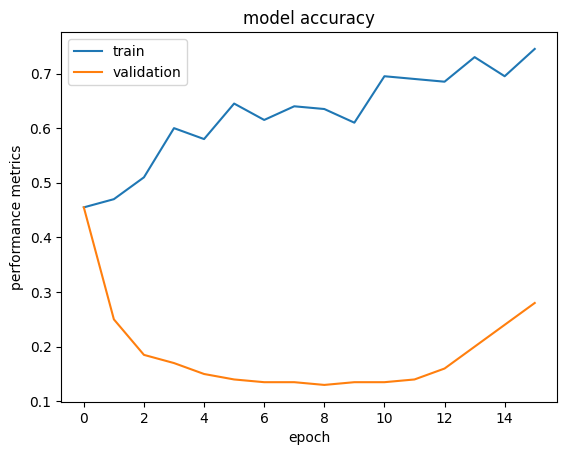

Epoch 1/16


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/7 [===>..........................] - ETA: 10s - loss: 256.6066 - binary_accuracy: 0.5000 - recall_m: 0.5000 - precision_m: 0.1250 - f1_m: 0.2000

7/7 [==============================] - 2s 61ms/step - loss: 293.3147 - binary_accuracy: 0.5200 - recall_m: 0.5000 - precision_m: 0.0962 - f1_m: 0.1504 - val_loss: 0.6609 - val_binary_accuracy: 0.8450 - val_recall_m: 0.0714 - val_precision_m: 0.0714 - val_f1_m: 0.0714
Epoch 2/16
1/7 [===>..........................] - ETA: 0s - loss: 324.8240 - binary_accuracy: 0.5938 - recall_m: 0.5000 - precision_m: 0.0769 - f1_m: 0.1333

7/7 [==============================] - 0s 14ms/step - loss: 270.7859 - binary_accuracy: 0.5600 - recall_m: 0.5782 - precision_m: 0.1163 - f1_m: 0.1878 - val_loss: 0.6608 - val_binary_accuracy: 0.8700 - val_recall_m: 0.2143 - val_precision_m: 0.2143 - val_f1_m: 0.2143
Epoch 3/16
1/7 [===>..........................] - ETA: 0s - loss: 299.3618 - binary_accuracy: 0.5000 - recall_m: 1.0000 - precision_m: 0.0588 - f1_m: 0.1111

7/7 [==============================] - 0s 13ms/step - loss: 247.0334 - binary_accuracy: 0.5350 - recall_m: 0.7143 - precision_m: 0.1458 - f1_m: 0.2276 - val_loss: 0.6582 - val_binary_accuracy: 0.8950 - val_recall_m: 0.2786 - val_precision_m: 0.4048 - val_f1_m: 0.3027
Epoch 4/16
1/7 [===>..........................] - ETA: 0s - loss: 196.9931 - binary_accuracy: 0.6875 - recall_m: 1.0000 - precision_m: 0.2308 - f1_m: 0.3750

7/7 [==============================] - 0s 11ms/step - loss: 219.9584 - binary_accuracy: 0.6350 - recall_m: 0.8571 - precision_m: 0.2868 - f1_m: 0.3778 - val_loss: 0.6544 - val_binary_accuracy: 0.9200 - val_recall_m: 0.3429 - val_precision_m: 0.5357 - val_f1_m: 0.4031
Epoch 5/16
1/7 [===>..........................] - ETA: 0s - loss: 222.8066 - binary_accuracy: 0.5938 - recall_m: 1.0000 - precision_m: 0.1333 - f1_m: 0.2353

7/7 [==============================] - 0s 12ms/step - loss: 216.2001 - binary_accuracy: 0.5900 - recall_m: 0.9116 - precision_m: 0.1746 - f1_m: 0.2819 - val_loss: 0.6501 - val_binary_accuracy: 0.9400 - val_recall_m: 0.4429 - val_precision_m: 0.5952 - val_f1_m: 0.4983
Epoch 6/16
1/7 [===>..........................] - ETA: 0s - loss: 184.1884 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.0833 - f1_m: 0.1538

7/7 [==============================] - 0s 13ms/step - loss: 192.3256 - binary_accuracy: 0.6850 - recall_m: 0.6762 - precision_m: 0.2156 - f1_m: 0.2955 - val_loss: 0.6479 - val_binary_accuracy: 0.9500 - val_recall_m: 0.4786 - val_precision_m: 0.6071 - val_f1_m: 0.5238
Epoch 7/16
1/7 [===>..........................] - ETA: 0s - loss: 155.5327 - binary_accuracy: 0.7500 - recall_m: 0.8000 - precision_m: 0.3636 - f1_m: 0.5000

7/7 [==============================] - 0s 12ms/step - loss: 206.3981 - binary_accuracy: 0.6450 - recall_m: 0.6952 - precision_m: 0.1612 - f1_m: 0.2504 - val_loss: 0.6424 - val_binary_accuracy: 0.9600 - val_recall_m: 0.5500 - val_precision_m: 0.6667 - val_f1_m: 0.5820
Epoch 8/16
1/7 [===>..........................] - ETA: 0s - loss: 193.3757 - binary_accuracy: 0.7188 - recall_m: 1.0000 - precision_m: 0.2500 - f1_m: 0.4000

7/7 [==============================] - 0s 11ms/step - loss: 191.4654 - binary_accuracy: 0.7100 - recall_m: 0.7143 - precision_m: 0.2093 - f1_m: 0.3232 - val_loss: 0.6363 - val_binary_accuracy: 0.9650 - val_recall_m: 0.5500 - val_precision_m: 0.6667 - val_f1_m: 0.5820
Epoch 9/16
1/7 [===>..........................] - ETA: 0s - loss: 149.6182 - binary_accuracy: 0.7500 - recall_m: 1.0000 - precision_m: 0.2727 - f1_m: 0.4286

7/7 [==============================] - 0s 11ms/step - loss: 176.7623 - binary_accuracy: 0.6900 - recall_m: 0.7643 - precision_m: 0.1918 - f1_m: 0.2968 - val_loss: 0.6285 - val_binary_accuracy: 0.9750 - val_recall_m: 0.6214 - val_precision_m: 0.7143 - val_f1_m: 0.6582
Epoch 10/16
1/7 [===>..........................] - ETA: 0s - loss: 211.9897 - binary_accuracy: 0.5938 - recall_m: 0.7500 - precision_m: 0.2000 - f1_m: 0.3158

7/7 [==============================] - 0s 11ms/step - loss: 182.1668 - binary_accuracy: 0.7050 - recall_m: 0.6548 - precision_m: 0.1815 - f1_m: 0.2784 - val_loss: 0.6195 - val_binary_accuracy: 0.9700 - val_recall_m: 0.5500 - val_precision_m: 0.7143 - val_f1_m: 0.6105
Epoch 11/16
1/7 [===>..........................] - ETA: 0s - loss: 190.7437 - binary_accuracy: 0.6875 - recall_m: 1.0000 - precision_m: 0.1667 - f1_m: 0.2857

7/7 [==============================] - 0s 11ms/step - loss: 178.6749 - binary_accuracy: 0.7000 - recall_m: 0.7643 - precision_m: 0.2622 - f1_m: 0.3673 - val_loss: 0.6108 - val_binary_accuracy: 0.9650 - val_recall_m: 0.5214 - val_precision_m: 0.7143 - val_f1_m: 0.5850
Epoch 12/16
1/7 [===>..........................] - ETA: 0s - loss: 197.8859 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.0769 - f1_m: 0.1429

7/7 [==============================] - 0s 12ms/step - loss: 167.0554 - binary_accuracy: 0.7450 - recall_m: 0.7857 - precision_m: 0.2607 - f1_m: 0.3677 - val_loss: 0.6009 - val_binary_accuracy: 0.9600 - val_recall_m: 0.4500 - val_precision_m: 0.7143 - val_f1_m: 0.5374
Epoch 13/16
1/7 [===>..........................] - ETA: 0s - loss: 133.8918 - binary_accuracy: 0.8125 - recall_m: 1.0000 - precision_m: 0.4000 - f1_m: 0.5714

7/7 [==============================] - 0s 12ms/step - loss: 149.7929 - binary_accuracy: 0.8050 - recall_m: 1.0000 - precision_m: 0.3500 - f1_m: 0.4957 - val_loss: 0.5903 - val_binary_accuracy: 0.9500 - val_recall_m: 0.3857 - val_precision_m: 0.7143 - val_f1_m: 0.4762
Epoch 14/16
1/7 [===>..........................] - ETA: 0s - loss: 205.0521 - binary_accuracy: 0.6875 - recall_m: 1.0000 - precision_m: 0.1667 - f1_m: 0.2857

7/7 [==============================] - 0s 11ms/step - loss: 156.6202 - binary_accuracy: 0.7800 - recall_m: 0.8571 - precision_m: 0.2695 - f1_m: 0.3850 - val_loss: 0.5818 - val_binary_accuracy: 0.9500 - val_recall_m: 0.3786 - val_precision_m: 0.7143 - val_f1_m: 0.4898
Epoch 15/16
1/7 [===>..........................] - ETA: 0s - loss: 152.7794 - binary_accuracy: 0.7812 - recall_m: 1.0000 - precision_m: 0.3000 - f1_m: 0.4615

7/7 [==============================] - 0s 14ms/step - loss: 152.0544 - binary_accuracy: 0.7800 - recall_m: 0.8952 - precision_m: 0.2887 - f1_m: 0.4289 - val_loss: 0.5716 - val_binary_accuracy: 0.9500 - val_recall_m: 0.3786 - val_precision_m: 0.7143 - val_f1_m: 0.4898
Epoch 16/16
1/7 [===>..........................] - ETA: 0s - loss: 192.8291 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.1538 - f1_m: 0.2667

7/7 [==============================] - 0s 3ms/step - loss: 0.5614 - binary_accuracy: 0.9550 - recall_m: 0.4500 - precision_m: 0.7143 - f1_m: 0.5374
Train Accuracy
7/7 [==============================] - 0s 3ms/step - loss: 0.5614 - binary_accuracy: 0.9550 - recall_m: 0.4500 - precision_m: 0.7143 - f1_m: 0.5374
Test Accuracy
7/7 [==============================] - 0s 3ms/step - loss: 0.5614 - binary_accuracy: 0.9550 - recall_m: 0.4500 - precision_m: 0.7143 - f1_m: 0.5374


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Current date: 2022-02-25 (3/12)


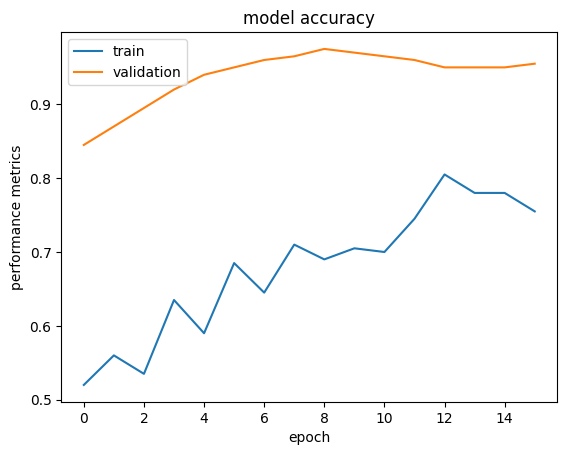

Epoch 1/16


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/7 [===>..........................] - ETA: 10s - loss: 0.9593 - binary_accuracy: 0.4375 - recall_m: 0.5000 - precision_m: 0.1111 - f1_m: 0.1818

7/7 [==============================] - 2s 67ms/step - loss: 1.1941 - binary_accuracy: 0.4800 - recall_m: 0.3762 - precision_m: 0.0984 - f1_m: 0.1551 - val_loss: 0.6940 - val_binary_accuracy: 0.5250 - val_recall_m: 0.7690 - val_precision_m: 0.1921 - val_f1_m: 0.2995
Epoch 2/16
1/7 [===>..........................] - ETA: 0s - loss: 0.7482 - binary_accuracy: 0.5000 - recall_m: 0.6667 - precision_m: 0.1176 - f1_m: 0.2000

7/7 [==============================] - 0s 13ms/step - loss: 0.8375 - binary_accuracy: 0.5450 - recall_m: 0.5286 - precision_m: 0.1320 - f1_m: 0.2077 - val_loss: 0.6847 - val_binary_accuracy: 0.6300 - val_recall_m: 0.8048 - val_precision_m: 0.2335 - val_f1_m: 0.3539
Epoch 3/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5358 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.2500 - f1_m: 0.4000

7/7 [==============================] - 0s 11ms/step - loss: 0.6138 - binary_accuracy: 0.6050 - recall_m: 0.7929 - precision_m: 0.1911 - f1_m: 0.3041 - val_loss: 0.6738 - val_binary_accuracy: 0.7100 - val_recall_m: 0.8333 - val_precision_m: 0.3009 - val_f1_m: 0.4304
Epoch 4/16
1/7 [===>..........................] - ETA: 0s - loss: 0.6507 - binary_accuracy: 0.4688 - recall_m: 1.0000 - precision_m: 0.1905 - f1_m: 0.3200

7/7 [==============================] - 0s 15ms/step - loss: 0.5699 - binary_accuracy: 0.6050 - recall_m: 0.7857 - precision_m: 0.2083 - f1_m: 0.3084 - val_loss: 0.6626 - val_binary_accuracy: 0.7900 - val_recall_m: 0.8333 - val_precision_m: 0.3745 - val_f1_m: 0.5022
Epoch 5/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5832 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.3529 - f1_m: 0.5217

7/7 [==============================] - 0s 12ms/step - loss: 0.5994 - binary_accuracy: 0.6050 - recall_m: 0.8929 - precision_m: 0.2760 - f1_m: 0.3872 - val_loss: 0.6488 - val_binary_accuracy: 0.8800 - val_recall_m: 0.8095 - val_precision_m: 0.5068 - val_f1_m: 0.6074
Epoch 6/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5630 - binary_accuracy: 0.5938 - recall_m: 1.0000 - precision_m: 0.1875 - f1_m: 0.3158

7/7 [==============================] - 0s 12ms/step - loss: 0.5119 - binary_accuracy: 0.6050 - recall_m: 0.9071 - precision_m: 0.2282 - f1_m: 0.3615 - val_loss: 0.6368 - val_binary_accuracy: 0.9150 - val_recall_m: 0.7738 - val_precision_m: 0.6071 - val_f1_m: 0.6455
Epoch 7/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4974 - binary_accuracy: 0.6875 - recall_m: 0.8571 - precision_m: 0.4000 - f1_m: 0.5455

7/7 [==============================] - 0s 13ms/step - loss: 0.5138 - binary_accuracy: 0.6500 - recall_m: 0.7724 - precision_m: 0.2185 - f1_m: 0.3322 - val_loss: 0.6235 - val_binary_accuracy: 0.9500 - val_recall_m: 0.7738 - val_precision_m: 0.8214 - val_f1_m: 0.7888
Epoch 8/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5148 - binary_accuracy: 0.5938 - recall_m: 0.7143 - precision_m: 0.3125 - f1_m: 0.4348

7/7 [==============================] - 0s 13ms/step - loss: 0.4548 - binary_accuracy: 0.6150 - recall_m: 0.9020 - precision_m: 0.2795 - f1_m: 0.3908 - val_loss: 0.6107 - val_binary_accuracy: 0.9650 - val_recall_m: 0.8095 - val_precision_m: 0.9000 - val_f1_m: 0.8365
Epoch 9/16
1/7 [===>..........................] - ETA: 0s - loss: 0.2982 - binary_accuracy: 0.8125 - recall_m: 1.0000 - precision_m: 0.4545 - f1_m: 0.6250

7/7 [==============================] - 0s 15ms/step - loss: 0.3659 - binary_accuracy: 0.7150 - recall_m: 0.9714 - precision_m: 0.2968 - f1_m: 0.4408 - val_loss: 0.5970 - val_binary_accuracy: 0.9600 - val_recall_m: 0.7500 - val_precision_m: 0.9643 - val_f1_m: 0.8214
Epoch 10/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5201 - binary_accuracy: 0.7500 - recall_m: 1.0000 - precision_m: 0.3333 - f1_m: 0.5000

7/7 [==============================] - 0s 13ms/step - loss: 0.4036 - binary_accuracy: 0.7000 - recall_m: 1.0000 - precision_m: 0.3861 - f1_m: 0.5079 - val_loss: 0.5817 - val_binary_accuracy: 0.9600 - val_recall_m: 0.7262 - val_precision_m: 1.0000 - val_f1_m: 0.8129
Epoch 11/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5363 - binary_accuracy: 0.5938 - recall_m: 0.6667 - precision_m: 0.1429 - f1_m: 0.2353

7/7 [==============================] - 0s 11ms/step - loss: 0.3970 - binary_accuracy: 0.6950 - recall_m: 0.9524 - precision_m: 0.3680 - f1_m: 0.4853 - val_loss: 0.5664 - val_binary_accuracy: 0.9450 - val_recall_m: 0.6310 - val_precision_m: 1.0000 - val_f1_m: 0.7170
Epoch 12/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3770 - binary_accuracy: 0.5938 - recall_m: 1.0000 - precision_m: 0.1875 - f1_m: 0.3158

7/7 [==============================] - 0s 13ms/step - loss: 0.3750 - binary_accuracy: 0.7200 - recall_m: 0.9357 - precision_m: 0.3324 - f1_m: 0.4738 - val_loss: 0.5553 - val_binary_accuracy: 0.9400 - val_recall_m: 0.5952 - val_precision_m: 1.0000 - val_f1_m: 0.6789
Epoch 13/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3768 - binary_accuracy: 0.8125 - recall_m: 1.0000 - precision_m: 0.4545 - f1_m: 0.6250

7/7 [==============================] - 0s 12ms/step - loss: 0.3245 - binary_accuracy: 0.7550 - recall_m: 1.0000 - precision_m: 0.4111 - f1_m: 0.5415 - val_loss: 0.5443 - val_binary_accuracy: 0.9400 - val_recall_m: 0.5952 - val_precision_m: 1.0000 - val_f1_m: 0.6789
Epoch 14/16
1/7 [===>..........................] - ETA: 0s - loss: 0.2716 - binary_accuracy: 0.8125 - recall_m: 1.0000 - precision_m: 0.4545 - f1_m: 0.6250

7/7 [==============================] - 0s 14ms/step - loss: 0.3152 - binary_accuracy: 0.7800 - recall_m: 0.9524 - precision_m: 0.3878 - f1_m: 0.5318 - val_loss: 0.5341 - val_binary_accuracy: 0.9450 - val_recall_m: 0.6190 - val_precision_m: 1.0000 - val_f1_m: 0.7095
Epoch 15/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3050 - binary_accuracy: 0.8125 - recall_m: 1.0000 - precision_m: 0.4545 - f1_m: 0.6250

7/7 [==============================] - 0s 11ms/step - loss: 0.3021 - binary_accuracy: 0.7850 - recall_m: 0.8571 - precision_m: 0.3293 - f1_m: 0.4579 - val_loss: 0.5219 - val_binary_accuracy: 0.9350 - val_recall_m: 0.5714 - val_precision_m: 0.8571 - val_f1_m: 0.6381
Epoch 16/16
1/7 [===>..........................] - ETA: 0s - loss: 0.2553 - binary_accuracy: 0.8438 - recall_m: 1.0000 - precision_m: 0.4444 - f1_m: 0.6154

7/7 [==============================] - 0s 3ms/step - loss: 0.5107 - binary_accuracy: 0.9350 - recall_m: 0.5714 - precision_m: 0.8571 - f1_m: 0.6381
Train Accuracy
7/7 [==============================] - 0s 4ms/step - loss: 0.5107 - binary_accuracy: 0.9350 - recall_m: 0.5714 - precision_m: 0.8571 - f1_m: 0.6381
Test Accuracy
7/7 [==============================] - 0s 3ms/step - loss: 0.5107 - binary_accuracy: 0.9350 - recall_m: 0.5714 - precision_m: 0.8571 - f1_m: 0.6381


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Current date: 2022-02-26 (4/12)


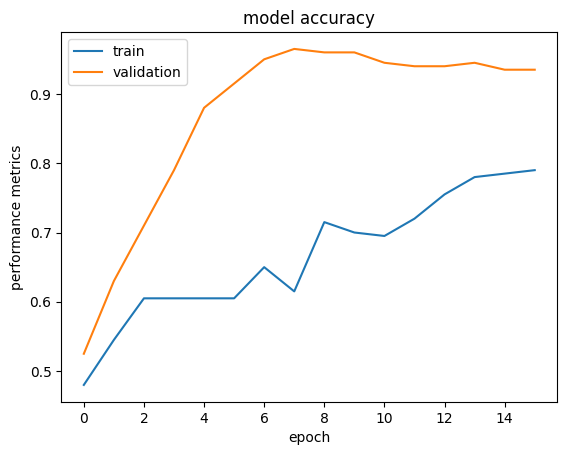

Epoch 1/16


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/7 [===>..........................] - ETA: 16s - loss: 0.4172 - binary_accuracy: 0.6562 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

7/7 [==============================] - 3s 63ms/step - loss: 0.6509 - binary_accuracy: 0.5350 - recall_m: 0.3429 - precision_m: 0.0548 - f1_m: 0.0914 - val_loss: 0.6801 - val_binary_accuracy: 0.8300 - val_recall_m: 0.1905 - val_precision_m: 0.1071 - val_f1_m: 0.1336
Epoch 2/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5984 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.1429 - f1_m: 0.2500

7/7 [==============================] - 0s 12ms/step - loss: 0.6483 - binary_accuracy: 0.5200 - recall_m: 0.4286 - precision_m: 0.1086 - f1_m: 0.1610 - val_loss: 0.6596 - val_binary_accuracy: 0.9600 - val_recall_m: 0.2381 - val_precision_m: 0.2857 - val_f1_m: 0.2571
Epoch 3/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4865 - binary_accuracy: 0.5938 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

7/7 [==============================] - 0s 11ms/step - loss: 0.5707 - binary_accuracy: 0.5650 - recall_m: 0.5238 - precision_m: 0.1000 - f1_m: 0.1610 - val_loss: 0.6395 - val_binary_accuracy: 0.9600 - val_recall_m: 0.0952 - val_precision_m: 0.1429 - val_f1_m: 0.1143
Epoch 4/16
1/7 [===>..........................] - ETA: 0s - loss: 0.6070 - binary_accuracy: 0.5312 - recall_m: 0.5000 - precision_m: 0.0667 - f1_m: 0.1176

7/7 [==============================] - 0s 12ms/step - loss: 0.5188 - binary_accuracy: 0.5350 - recall_m: 0.5952 - precision_m: 0.0671 - f1_m: 0.1176 - val_loss: 0.6195 - val_binary_accuracy: 0.9500 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 5/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5600 - binary_accuracy: 0.6250 - recall_m: 0.6667 - precision_m: 0.1538 - f1_m: 0.2500

7/7 [==============================] - 0s 12ms/step - loss: 0.4476 - binary_accuracy: 0.6350 - recall_m: 0.6667 - precision_m: 0.0970 - f1_m: 0.1665 - val_loss: 0.6015 - val_binary_accuracy: 0.9500 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 6/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4999 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.0769 - f1_m: 0.1429

7/7 [==============================] - 0s 13ms/step - loss: 0.4412 - binary_accuracy: 0.6350 - recall_m: 0.6429 - precision_m: 0.1027 - f1_m: 0.1697 - val_loss: 0.5838 - val_binary_accuracy: 0.9500 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 7/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3759 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.1538 - f1_m: 0.2667

7/7 [==============================] - 0s 13ms/step - loss: 0.3822 - binary_accuracy: 0.6500 - recall_m: 0.7143 - precision_m: 0.1091 - f1_m: 0.1882 - val_loss: 0.5653 - val_binary_accuracy: 0.9500 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 8/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3864 - binary_accuracy: 0.7188 - recall_m: 1.0000 - precision_m: 0.1000 - f1_m: 0.1818

7/7 [==============================] - 0s 15ms/step - loss: 0.3994 - binary_accuracy: 0.6750 - recall_m: 0.7143 - precision_m: 0.1233 - f1_m: 0.1944 - val_loss: 0.5463 - val_binary_accuracy: 0.9500 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 9/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4749 - binary_accuracy: 0.6875 - recall_m: 0.5000 - precision_m: 0.1000 - f1_m: 0.1667

7/7 [==============================] - 0s 13ms/step - loss: 0.4328 - binary_accuracy: 0.6500 - recall_m: 0.4167 - precision_m: 0.0935 - f1_m: 0.1477 - val_loss: 0.5318 - val_binary_accuracy: 0.9500 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 10/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4094 - binary_accuracy: 0.5938 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

7/7 [==============================] - 0s 12ms/step - loss: 0.3856 - binary_accuracy: 0.6200 - recall_m: 0.4286 - precision_m: 0.1083 - f1_m: 0.1687 - val_loss: 0.5169 - val_binary_accuracy: 0.9500 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 11/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3999 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.1538 - f1_m: 0.2667

7/7 [==============================] - 0s 12ms/step - loss: 0.3417 - binary_accuracy: 0.6750 - recall_m: 0.7143 - precision_m: 0.1347 - f1_m: 0.2219 - val_loss: 0.5019 - val_binary_accuracy: 0.9500 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 12/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3097 - binary_accuracy: 0.7188 - recall_m: 1.0000 - precision_m: 0.1000 - f1_m: 0.1818

7/7 [==============================] - 0s 13ms/step - loss: 0.3236 - binary_accuracy: 0.7300 - recall_m: 1.0000 - precision_m: 0.1896 - f1_m: 0.3031 - val_loss: 0.4894 - val_binary_accuracy: 0.9500 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 13/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3397 - binary_accuracy: 0.7188 - recall_m: 1.0000 - precision_m: 0.1000 - f1_m: 0.1818

7/7 [==============================] - 0s 13ms/step - loss: 0.3514 - binary_accuracy: 0.7000 - recall_m: 0.7143 - precision_m: 0.2331 - f1_m: 0.2944 - val_loss: 0.4745 - val_binary_accuracy: 0.9500 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 14/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3444 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.0769 - f1_m: 0.1429

7/7 [==============================] - 0s 13ms/step - loss: 0.3211 - binary_accuracy: 0.7100 - recall_m: 0.7143 - precision_m: 0.1800 - f1_m: 0.2580 - val_loss: 0.4618 - val_binary_accuracy: 0.9500 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 15/16
1/7 [===>..........................] - ETA: 0s - loss: 0.2581 - binary_accuracy: 0.7812 - recall_m: 1.0000 - precision_m: 0.1250 - f1_m: 0.2222

7/7 [==============================] - 0s 13ms/step - loss: 0.3217 - binary_accuracy: 0.7700 - recall_m: 0.7143 - precision_m: 0.1699 - f1_m: 0.2641 - val_loss: 0.4477 - val_binary_accuracy: 0.9500 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 16/16
1/7 [===>..........................] - ETA: 0s - loss: 0.2656 - binary_accuracy: 0.8125 - recall_m: 1.0000 - precision_m: 0.2500 - f1_m: 0.4000

7/7 [==============================] - 0s 3ms/step - loss: 0.4356 - binary_accuracy: 0.9500 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00
Train Accuracy
7/7 [==============================] - 0s 4ms/step - loss: 0.4356 - binary_accuracy: 0.9500 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00
Test Accuracy
7/7 [==============================] - 0s 3ms/step - loss: 0.4356 - binary_accuracy: 0.9500 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Current date: 2022-02-27 (5/12)


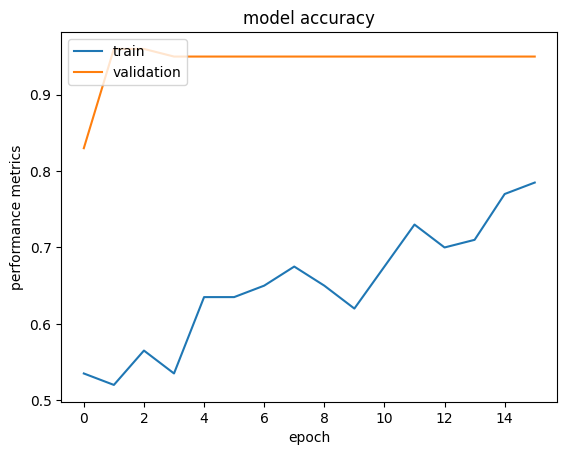

Epoch 1/16


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/7 [===>..........................] - ETA: 10s - loss: 271.3983 - binary_accuracy: 0.4688 - recall_m: 0.4000 - precision_m: 0.1250 - f1_m: 0.1905

7/7 [==============================] - 2s 62ms/step - loss: 289.1229 - binary_accuracy: 0.5000 - recall_m: 0.3857 - precision_m: 0.1130 - f1_m: 0.1734 - val_loss: 0.6902 - val_binary_accuracy: 0.6050 - val_recall_m: 0.6667 - val_precision_m: 0.2616 - val_f1_m: 0.3569
Epoch 2/16
1/7 [===>..........................] - ETA: 0s - loss: 145.6817 - binary_accuracy: 0.7812 - recall_m: 0.7778 - precision_m: 0.5833 - f1_m: 0.6667

7/7 [==============================] - 0s 12ms/step - loss: 231.0495 - binary_accuracy: 0.6050 - recall_m: 0.7540 - precision_m: 0.2140 - f1_m: 0.3079 - val_loss: 0.6676 - val_binary_accuracy: 0.8400 - val_recall_m: 0.5429 - val_precision_m: 0.4126 - val_f1_m: 0.4536
Epoch 3/16
1/7 [===>..........................] - ETA: 0s - loss: 224.7340 - binary_accuracy: 0.6250 - recall_m: 0.5000 - precision_m: 0.0833 - f1_m: 0.1429

7/7 [==============================] - 0s 11ms/step - loss: 195.6675 - binary_accuracy: 0.6400 - recall_m: 0.6714 - precision_m: 0.2135 - f1_m: 0.3205 - val_loss: 0.6427 - val_binary_accuracy: 0.8900 - val_recall_m: 0.1429 - val_precision_m: 0.3571 - val_f1_m: 0.2041
Epoch 4/16
1/7 [===>..........................] - ETA: 0s - loss: 182.4303 - binary_accuracy: 0.7188 - recall_m: 1.0000 - precision_m: 0.3077 - f1_m: 0.4706

7/7 [==============================] - 0s 13ms/step - loss: 185.3596 - binary_accuracy: 0.7000 - recall_m: 0.8810 - precision_m: 0.2842 - f1_m: 0.4248 - val_loss: 0.6171 - val_binary_accuracy: 0.8800 - val_recall_m: 0.0571 - val_precision_m: 0.2857 - val_f1_m: 0.0952
Epoch 5/16
1/7 [===>..........................] - ETA: 0s - loss: 157.8587 - binary_accuracy: 0.7500 - recall_m: 0.8333 - precision_m: 0.4167 - f1_m: 0.5556

7/7 [==============================] - 0s 13ms/step - loss: 192.4130 - binary_accuracy: 0.6700 - recall_m: 0.8048 - precision_m: 0.2396 - f1_m: 0.3587 - val_loss: 0.5982 - val_binary_accuracy: 0.8750 - val_recall_m: 0.0286 - val_precision_m: 0.1429 - val_f1_m: 0.0476
Epoch 6/16
1/7 [===>..........................] - ETA: 0s - loss: 177.4677 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.2143 - f1_m: 0.3529

7/7 [==============================] - 0s 12ms/step - loss: 187.1304 - binary_accuracy: 0.6750 - recall_m: 0.8010 - precision_m: 0.2671 - f1_m: 0.3765 - val_loss: 0.5811 - val_binary_accuracy: 0.8750 - val_recall_m: 0.0286 - val_precision_m: 0.1429 - val_f1_m: 0.0476
Epoch 7/16
1/7 [===>..........................] - ETA: 0s - loss: 170.0865 - binary_accuracy: 0.7500 - recall_m: 0.8333 - precision_m: 0.4167 - f1_m: 0.5556

7/7 [==============================] - 0s 12ms/step - loss: 189.1478 - binary_accuracy: 0.7100 - recall_m: 0.8333 - precision_m: 0.2779 - f1_m: 0.4023 - val_loss: 0.5629 - val_binary_accuracy: 0.8750 - val_recall_m: 0.0286 - val_precision_m: 0.1429 - val_f1_m: 0.0476
Epoch 8/16
1/7 [===>..........................] - ETA: 0s - loss: 115.6088 - binary_accuracy: 0.9062 - recall_m: 1.0000 - precision_m: 0.6667 - f1_m: 0.8000

7/7 [==============================] - 0s 13ms/step - loss: 158.7670 - binary_accuracy: 0.7600 - recall_m: 0.7976 - precision_m: 0.3840 - f1_m: 0.5010 - val_loss: 0.5454 - val_binary_accuracy: 0.8700 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 9/16
1/7 [===>..........................] - ETA: 0s - loss: 177.6599 - binary_accuracy: 0.7500 - recall_m: 1.0000 - precision_m: 0.2727 - f1_m: 0.4286

7/7 [==============================] - 0s 12ms/step - loss: 163.5965 - binary_accuracy: 0.7250 - recall_m: 0.9000 - precision_m: 0.3082 - f1_m: 0.4533 - val_loss: 0.5293 - val_binary_accuracy: 0.8700 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 10/16
1/7 [===>..........................] - ETA: 0s - loss: 134.6036 - binary_accuracy: 0.8438 - recall_m: 0.8750 - precision_m: 0.6364 - f1_m: 0.7368

7/7 [==============================] - 0s 14ms/step - loss: 173.8514 - binary_accuracy: 0.7000 - recall_m: 0.7679 - precision_m: 0.2690 - f1_m: 0.3782 - val_loss: 0.5140 - val_binary_accuracy: 0.8700 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 11/16
1/7 [===>..........................] - ETA: 0s - loss: 164.3660 - binary_accuracy: 0.7812 - recall_m: 1.0000 - precision_m: 0.4167 - f1_m: 0.5882

7/7 [==============================] - 0s 11ms/step - loss: 151.5238 - binary_accuracy: 0.7850 - recall_m: 0.9524 - precision_m: 0.4082 - f1_m: 0.5602 - val_loss: 0.4995 - val_binary_accuracy: 0.8700 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 12/16
1/7 [===>..........................] - ETA: 0s - loss: 152.5400 - binary_accuracy: 0.7812 - recall_m: 0.8333 - precision_m: 0.4545 - f1_m: 0.5882

7/7 [==============================] - 0s 12ms/step - loss: 145.7300 - binary_accuracy: 0.8050 - recall_m: 0.9048 - precision_m: 0.4025 - f1_m: 0.5389 - val_loss: 0.4844 - val_binary_accuracy: 0.8700 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 13/16
1/7 [===>..........................] - ETA: 0s - loss: 182.3508 - binary_accuracy: 0.7812 - recall_m: 1.0000 - precision_m: 0.2222 - f1_m: 0.3636

7/7 [==============================] - 0s 12ms/step - loss: 133.6599 - binary_accuracy: 0.8200 - recall_m: 0.9286 - precision_m: 0.4294 - f1_m: 0.5595 - val_loss: 0.4686 - val_binary_accuracy: 0.8700 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 14/16
1/7 [===>..........................] - ETA: 0s - loss: 116.4560 - binary_accuracy: 0.8750 - recall_m: 1.0000 - precision_m: 0.5556 - f1_m: 0.7143

7/7 [==============================] - 0s 12ms/step - loss: 123.4493 - binary_accuracy: 0.8650 - recall_m: 1.0000 - precision_m: 0.5569 - f1_m: 0.6925 - val_loss: 0.4543 - val_binary_accuracy: 0.8700 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 15/16
1/7 [===>..........................] - ETA: 0s - loss: 235.4348 - binary_accuracy: 0.6250 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

7/7 [==============================] - 0s 19ms/step - loss: 142.3627 - binary_accuracy: 0.8200 - recall_m: 0.8367 - precision_m: 0.5132 - f1_m: 0.6030 - val_loss: 0.4408 - val_binary_accuracy: 0.8700 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 16/16
1/7 [===>..........................] - ETA: 0s - loss: 172.7340 - binary_accuracy: 0.7188 - recall_m: 1.0000 - precision_m: 0.1818 - f1_m: 0.3077

7/7 [==============================] - 0s 7ms/step - loss: 0.4284 - binary_accuracy: 0.8700 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00
Train Accuracy
7/7 [==============================] - 0s 4ms/step - loss: 0.4284 - binary_accuracy: 0.8700 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00
Test Accuracy
7/7 [==============================] - 0s 4ms/step - loss: 0.4284 - binary_accuracy: 0.8700 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Current date: 2022-02-28 (6/12)


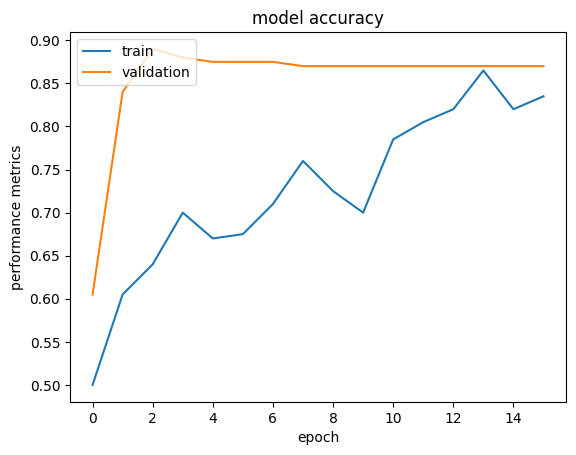

Epoch 1/16


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/7 [===>..........................] - ETA: 10s - loss: 1.1668 - binary_accuracy: 0.5000 - recall_m: 0.3333 - precision_m: 0.1429 - f1_m: 0.2000

7/7 [==============================] - 2s 64ms/step - loss: 1.1551 - binary_accuracy: 0.4850 - recall_m: 0.1119 - precision_m: 0.0395 - f1_m: 0.0580 - val_loss: 0.6860 - val_binary_accuracy: 0.6850 - val_recall_m: 0.3993 - val_precision_m: 0.2035 - val_f1_m: 0.2503
Epoch 2/16
1/7 [===>..........................] - ETA: 0s - loss: 0.8978 - binary_accuracy: 0.5312 - recall_m: 0.7500 - precision_m: 0.1765 - f1_m: 0.2857

7/7 [==============================] - 0s 12ms/step - loss: 0.8695 - binary_accuracy: 0.5550 - recall_m: 0.4464 - precision_m: 0.1256 - f1_m: 0.1928 - val_loss: 0.6815 - val_binary_accuracy: 0.7900 - val_recall_m: 0.5078 - val_precision_m: 0.3090 - val_f1_m: 0.3594
Epoch 3/16
1/7 [===>..........................] - ETA: 0s - loss: 0.7404 - binary_accuracy: 0.5000 - recall_m: 0.5000 - precision_m: 0.0625 - f1_m: 0.1111

7/7 [==============================] - 0s 12ms/step - loss: 0.7117 - binary_accuracy: 0.5850 - recall_m: 0.7687 - precision_m: 0.2304 - f1_m: 0.3363 - val_loss: 0.6709 - val_binary_accuracy: 0.8350 - val_recall_m: 0.3721 - val_precision_m: 0.3935 - val_f1_m: 0.3605
Epoch 4/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4623 - binary_accuracy: 0.5938 - recall_m: 1.0000 - precision_m: 0.0714 - f1_m: 0.1333

7/7 [==============================] - 0s 15ms/step - loss: 0.6074 - binary_accuracy: 0.6250 - recall_m: 0.9190 - precision_m: 0.2348 - f1_m: 0.3416 - val_loss: 0.6609 - val_binary_accuracy: 0.8600 - val_recall_m: 0.3517 - val_precision_m: 0.4500 - val_f1_m: 0.3730
Epoch 5/16
1/7 [===>..........................] - ETA: 0s - loss: 0.6370 - binary_accuracy: 0.6562 - recall_m: 0.8571 - precision_m: 0.3750 - f1_m: 0.5217

7/7 [==============================] - 0s 13ms/step - loss: 0.5583 - binary_accuracy: 0.6300 - recall_m: 0.7439 - precision_m: 0.2224 - f1_m: 0.3305 - val_loss: 0.6474 - val_binary_accuracy: 0.9050 - val_recall_m: 0.2874 - val_precision_m: 0.6786 - val_f1_m: 0.3970
Epoch 6/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5073 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.2667 - f1_m: 0.4211

7/7 [==============================] - 0s 13ms/step - loss: 0.5427 - binary_accuracy: 0.6750 - recall_m: 0.7605 - precision_m: 0.2493 - f1_m: 0.3624 - val_loss: 0.6348 - val_binary_accuracy: 0.9050 - val_recall_m: 0.2636 - val_precision_m: 0.7143 - val_f1_m: 0.3741
Epoch 7/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4067 - binary_accuracy: 0.5938 - recall_m: 1.0000 - precision_m: 0.1875 - f1_m: 0.3158

7/7 [==============================] - 0s 13ms/step - loss: 0.5541 - binary_accuracy: 0.6150 - recall_m: 0.9034 - precision_m: 0.2886 - f1_m: 0.4154 - val_loss: 0.6213 - val_binary_accuracy: 0.8950 - val_recall_m: 0.2075 - val_precision_m: 0.5714 - val_f1_m: 0.2948
Epoch 8/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4219 - binary_accuracy: 0.6875 - recall_m: 1.0000 - precision_m: 0.1667 - f1_m: 0.2857

7/7 [==============================] - 0s 14ms/step - loss: 0.4875 - binary_accuracy: 0.7000 - recall_m: 0.7937 - precision_m: 0.2516 - f1_m: 0.3524 - val_loss: 0.6091 - val_binary_accuracy: 0.8900 - val_recall_m: 0.1837 - val_precision_m: 0.4286 - val_f1_m: 0.2540
Epoch 9/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4209 - binary_accuracy: 0.7812 - recall_m: 1.0000 - precision_m: 0.4615 - f1_m: 0.6316

7/7 [==============================] - 0s 12ms/step - loss: 0.5083 - binary_accuracy: 0.6550 - recall_m: 0.9082 - precision_m: 0.2775 - f1_m: 0.4010 - val_loss: 0.5972 - val_binary_accuracy: 0.8800 - val_recall_m: 0.0918 - val_precision_m: 0.2857 - val_f1_m: 0.1310
Epoch 10/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3772 - binary_accuracy: 0.8438 - recall_m: 1.0000 - precision_m: 0.5000 - f1_m: 0.6667

7/7 [==============================] - 0s 15ms/step - loss: 0.3940 - binary_accuracy: 0.7000 - recall_m: 0.9643 - precision_m: 0.3115 - f1_m: 0.4618 - val_loss: 0.5860 - val_binary_accuracy: 0.8750 - val_recall_m: 0.0714 - val_precision_m: 0.1429 - val_f1_m: 0.0952
Epoch 11/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4440 - binary_accuracy: 0.7188 - recall_m: 1.0000 - precision_m: 0.2500 - f1_m: 0.4000

7/7 [==============================] - 0s 13ms/step - loss: 0.4345 - binary_accuracy: 0.7500 - recall_m: 0.7643 - precision_m: 0.2963 - f1_m: 0.4226 - val_loss: 0.5754 - val_binary_accuracy: 0.8700 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 12/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4235 - binary_accuracy: 0.8438 - recall_m: 1.0000 - precision_m: 0.5000 - f1_m: 0.6667

7/7 [==============================] - 0s 13ms/step - loss: 0.4309 - binary_accuracy: 0.7350 - recall_m: 0.9286 - precision_m: 0.3594 - f1_m: 0.4869 - val_loss: 0.5656 - val_binary_accuracy: 0.8700 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 13/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3264 - binary_accuracy: 0.6875 - recall_m: 1.0000 - precision_m: 0.2857 - f1_m: 0.4444

7/7 [==============================] - 0s 13ms/step - loss: 0.3578 - binary_accuracy: 0.7700 - recall_m: 0.8571 - precision_m: 0.3300 - f1_m: 0.4733 - val_loss: 0.5540 - val_binary_accuracy: 0.8700 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 14/16
1/7 [===>..........................] - ETA: 0s - loss: 0.6965 - binary_accuracy: 0.7188 - recall_m: 0.5000 - precision_m: 0.3333 - f1_m: 0.4000

7/7 [==============================] - 0s 13ms/step - loss: 0.4026 - binary_accuracy: 0.7500 - recall_m: 0.8571 - precision_m: 0.3255 - f1_m: 0.4595 - val_loss: 0.5433 - val_binary_accuracy: 0.8700 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 15/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3342 - binary_accuracy: 0.8438 - recall_m: 1.0000 - precision_m: 0.5000 - f1_m: 0.6667

7/7 [==============================] - 0s 15ms/step - loss: 0.3150 - binary_accuracy: 0.7900 - recall_m: 1.0000 - precision_m: 0.4312 - f1_m: 0.5777 - val_loss: 0.5343 - val_binary_accuracy: 0.8700 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 16/16
1/7 [===>..........................] - ETA: 0s - loss: 0.2810 - binary_accuracy: 0.9062 - recall_m: 1.0000 - precision_m: 0.6667 - f1_m: 0.8000

7/7 [==============================] - 0s 3ms/step - loss: 0.5243 - binary_accuracy: 0.8700 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00
Train Accuracy
7/7 [==============================] - 0s 3ms/step - loss: 0.5243 - binary_accuracy: 0.8700 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00
Test Accuracy
7/7 [==============================] - 0s 4ms/step - loss: 0.5243 - binary_accuracy: 0.8700 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Current date: 2022-03-01 (7/12)


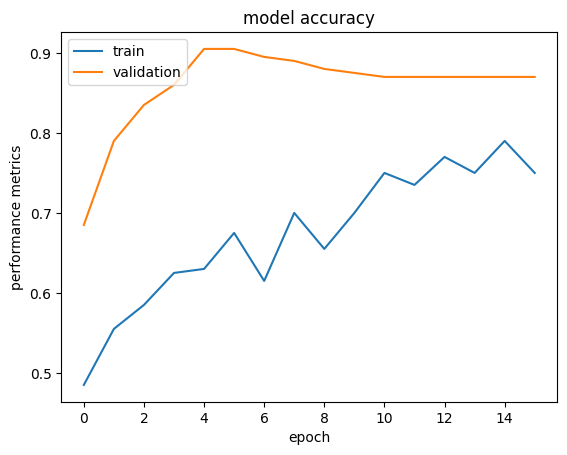

Epoch 1/16


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/7 [===>..........................] - ETA: 14s - loss: 0.4829 - binary_accuracy: 0.6875 - recall_m: 1.0000 - precision_m: 0.2857 - f1_m: 0.4444

7/7 [==============================] - 3s 101ms/step - loss: 0.8930 - binary_accuracy: 0.5400 - recall_m: 0.5031 - precision_m: 0.1259 - f1_m: 0.1916 - val_loss: 0.6788 - val_binary_accuracy: 0.7600 - val_recall_m: 0.7357 - val_precision_m: 0.3029 - val_f1_m: 0.4248
Epoch 2/16
1/7 [===>..........................] - ETA: 0s - loss: 0.7993 - binary_accuracy: 0.4375 - recall_m: 0.5000 - precision_m: 0.0556 - f1_m: 0.1000

7/7 [==============================] - 0s 13ms/step - loss: 0.6526 - binary_accuracy: 0.6150 - recall_m: 0.6259 - precision_m: 0.1923 - f1_m: 0.2825 - val_loss: 0.6775 - val_binary_accuracy: 0.7500 - val_recall_m: 0.8786 - val_precision_m: 0.3174 - val_f1_m: 0.4570
Epoch 3/16
1/7 [===>..........................] - ETA: 0s - loss: 0.6156 - binary_accuracy: 0.6250 - recall_m: 0.8571 - precision_m: 0.3529 - f1_m: 0.5000

7/7 [==============================] - 0s 14ms/step - loss: 0.5501 - binary_accuracy: 0.5950 - recall_m: 0.8129 - precision_m: 0.2114 - f1_m: 0.3280 - val_loss: 0.6699 - val_binary_accuracy: 0.8100 - val_recall_m: 0.9071 - val_precision_m: 0.4010 - val_f1_m: 0.5457
Epoch 4/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5342 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.2143 - f1_m: 0.3529

7/7 [==============================] - 0s 13ms/step - loss: 0.5672 - binary_accuracy: 0.6300 - recall_m: 0.7798 - precision_m: 0.2219 - f1_m: 0.3189 - val_loss: 0.6626 - val_binary_accuracy: 0.8750 - val_recall_m: 0.9429 - val_precision_m: 0.5735 - val_f1_m: 0.6973
Epoch 5/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3719 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.2667 - f1_m: 0.4211

7/7 [==============================] - 0s 14ms/step - loss: 0.4486 - binary_accuracy: 0.6550 - recall_m: 1.0000 - precision_m: 0.2701 - f1_m: 0.4177 - val_loss: 0.6534 - val_binary_accuracy: 0.9350 - val_recall_m: 0.9429 - val_precision_m: 0.7524 - val_f1_m: 0.8190
Epoch 6/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4017 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.1538 - f1_m: 0.2667

7/7 [==============================] - 0s 12ms/step - loss: 0.4315 - binary_accuracy: 0.6550 - recall_m: 0.8571 - precision_m: 0.2438 - f1_m: 0.3594 - val_loss: 0.6437 - val_binary_accuracy: 0.9600 - val_recall_m: 0.9143 - val_precision_m: 0.8690 - val_f1_m: 0.8794
Epoch 7/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3121 - binary_accuracy: 0.7188 - recall_m: 1.0000 - precision_m: 0.2500 - f1_m: 0.4000

7/7 [==============================] - 0s 13ms/step - loss: 0.4098 - binary_accuracy: 0.7100 - recall_m: 0.9643 - precision_m: 0.3013 - f1_m: 0.4554 - val_loss: 0.6320 - val_binary_accuracy: 0.9700 - val_recall_m: 0.8429 - val_precision_m: 0.9643 - val_f1_m: 0.8957
Epoch 8/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3978 - binary_accuracy: 0.7188 - recall_m: 0.8000 - precision_m: 0.3333 - f1_m: 0.4706

7/7 [==============================] - 0s 14ms/step - loss: 0.4761 - binary_accuracy: 0.7000 - recall_m: 0.7524 - precision_m: 0.2634 - f1_m: 0.3638 - val_loss: 0.6200 - val_binary_accuracy: 0.9750 - val_recall_m: 0.8429 - val_precision_m: 1.0000 - val_f1_m: 0.9076
Epoch 9/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3037 - binary_accuracy: 0.7188 - recall_m: 1.0000 - precision_m: 0.2500 - f1_m: 0.4000

7/7 [==============================] - 0s 15ms/step - loss: 0.3673 - binary_accuracy: 0.7150 - recall_m: 1.0000 - precision_m: 0.3073 - f1_m: 0.4642 - val_loss: 0.6107 - val_binary_accuracy: 0.9650 - val_recall_m: 0.7357 - val_precision_m: 1.0000 - val_f1_m: 0.8396
Epoch 10/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3798 - binary_accuracy: 0.6875 - recall_m: 1.0000 - precision_m: 0.2857 - f1_m: 0.4444

7/7 [==============================] - 0s 12ms/step - loss: 0.3429 - binary_accuracy: 0.7450 - recall_m: 1.0000 - precision_m: 0.3297 - f1_m: 0.4879 - val_loss: 0.6000 - val_binary_accuracy: 0.9650 - val_recall_m: 0.7357 - val_precision_m: 1.0000 - val_f1_m: 0.8396
Epoch 11/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3385 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.1538 - f1_m: 0.2667

7/7 [==============================] - 0s 13ms/step - loss: 0.3949 - binary_accuracy: 0.7550 - recall_m: 0.8393 - precision_m: 0.3134 - f1_m: 0.4159 - val_loss: 0.5888 - val_binary_accuracy: 0.9600 - val_recall_m: 0.7000 - val_precision_m: 1.0000 - val_f1_m: 0.8124
Epoch 12/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4111 - binary_accuracy: 0.6562 - recall_m: 0.5000 - precision_m: 0.0909 - f1_m: 0.1538

7/7 [==============================] - 0s 13ms/step - loss: 0.3286 - binary_accuracy: 0.7600 - recall_m: 0.9286 - precision_m: 0.3423 - f1_m: 0.4802 - val_loss: 0.5783 - val_binary_accuracy: 0.9600 - val_recall_m: 0.7000 - val_precision_m: 1.0000 - val_f1_m: 0.8124
Epoch 13/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4027 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.0833 - f1_m: 0.1538

7/7 [==============================] - 0s 15ms/step - loss: 0.3067 - binary_accuracy: 0.7350 - recall_m: 1.0000 - precision_m: 0.3333 - f1_m: 0.4751 - val_loss: 0.5672 - val_binary_accuracy: 0.9650 - val_recall_m: 0.7286 - val_precision_m: 1.0000 - val_f1_m: 0.8282
Epoch 14/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4108 - binary_accuracy: 0.8750 - recall_m: 1.0000 - precision_m: 0.6000 - f1_m: 0.7500

7/7 [==============================] - 0s 14ms/step - loss: 0.3462 - binary_accuracy: 0.7750 - recall_m: 0.9762 - precision_m: 0.4329 - f1_m: 0.5535 - val_loss: 0.5566 - val_binary_accuracy: 0.9600 - val_recall_m: 0.7000 - val_precision_m: 1.0000 - val_f1_m: 0.8027
Epoch 15/16
1/7 [===>..........................] - ETA: 0s - loss: 0.2357 - binary_accuracy: 0.9062 - recall_m: 1.0000 - precision_m: 0.7000 - f1_m: 0.8235

7/7 [==============================] - 0s 14ms/step - loss: 0.2947 - binary_accuracy: 0.7950 - recall_m: 0.8571 - precision_m: 0.3645 - f1_m: 0.4738 - val_loss: 0.5457 - val_binary_accuracy: 0.9500 - val_recall_m: 0.6286 - val_precision_m: 1.0000 - val_f1_m: 0.7374
Epoch 16/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3439 - binary_accuracy: 0.8125 - recall_m: 1.0000 - precision_m: 0.4000 - f1_m: 0.5714

7/7 [==============================] - 0s 4ms/step - loss: 0.5372 - binary_accuracy: 0.9500 - recall_m: 0.6286 - precision_m: 1.0000 - f1_m: 0.7374
Train Accuracy
7/7 [==============================] - 0s 3ms/step - loss: 0.5372 - binary_accuracy: 0.9500 - recall_m: 0.6286 - precision_m: 1.0000 - f1_m: 0.7374
Test Accuracy
7/7 [==============================] - 0s 5ms/step - loss: 0.5372 - binary_accuracy: 0.9500 - recall_m: 0.6286 - precision_m: 1.0000 - f1_m: 0.7374


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Current date: 2022-03-02 (8/12)


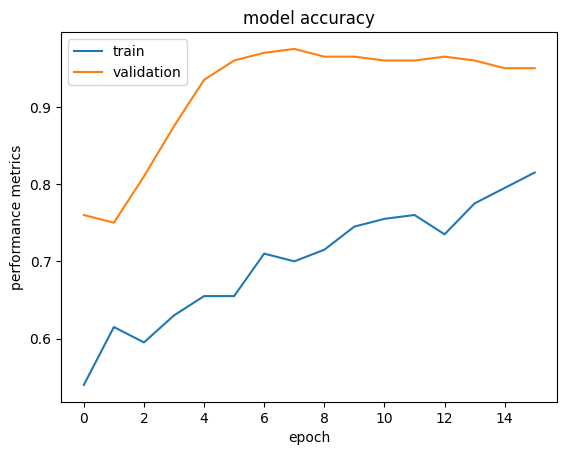

Epoch 1/16


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/7 [===>..........................] - ETA: 14s - loss: 0.9000 - binary_accuracy: 0.5000 - recall_m: 0.6667 - precision_m: 0.1176 - f1_m: 0.2000

7/7 [==============================] - 3s 88ms/step - loss: 1.0104 - binary_accuracy: 0.4850 - recall_m: 0.3095 - precision_m: 0.0550 - f1_m: 0.0916 - val_loss: 0.6932 - val_binary_accuracy: 0.5150 - val_recall_m: 0.6667 - val_precision_m: 0.1348 - val_f1_m: 0.2230
Epoch 2/16
1/7 [===>..........................] - ETA: 0s - loss: 0.9770 - binary_accuracy: 0.5625 - recall_m: 0.5000 - precision_m: 0.1429 - f1_m: 0.2222

7/7 [==============================] - 0s 14ms/step - loss: 0.7286 - binary_accuracy: 0.5650 - recall_m: 0.7571 - precision_m: 0.1475 - f1_m: 0.2408 - val_loss: 0.6860 - val_binary_accuracy: 0.6200 - val_recall_m: 0.7619 - val_precision_m: 0.1759 - val_f1_m: 0.2846
Epoch 3/16
1/7 [===>..........................] - ETA: 0s - loss: 0.6062 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.1429 - f1_m: 0.2500

7/7 [==============================] - 0s 13ms/step - loss: 0.7716 - binary_accuracy: 0.5400 - recall_m: 0.8333 - precision_m: 0.1552 - f1_m: 0.2467 - val_loss: 0.6741 - val_binary_accuracy: 0.7450 - val_recall_m: 0.7619 - val_precision_m: 0.2429 - val_f1_m: 0.3658
Epoch 4/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4807 - binary_accuracy: 0.5938 - recall_m: 1.0000 - precision_m: 0.0714 - f1_m: 0.1333

7/7 [==============================] - 0s 14ms/step - loss: 0.5679 - binary_accuracy: 0.6150 - recall_m: 0.9000 - precision_m: 0.2040 - f1_m: 0.3157 - val_loss: 0.6628 - val_binary_accuracy: 0.8700 - val_recall_m: 0.6667 - val_precision_m: 0.4109 - val_f1_m: 0.5014
Epoch 5/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5065 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.0833 - f1_m: 0.1538

7/7 [==============================] - 0s 15ms/step - loss: 0.5357 - binary_accuracy: 0.6150 - recall_m: 0.8333 - precision_m: 0.1742 - f1_m: 0.2752 - val_loss: 0.6533 - val_binary_accuracy: 0.9150 - val_recall_m: 0.6667 - val_precision_m: 0.5595 - val_f1_m: 0.5946
Epoch 6/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4691 - binary_accuracy: 0.5312 - recall_m: 1.0000 - precision_m: 0.1176 - f1_m: 0.2105

7/7 [==============================] - 0s 13ms/step - loss: 0.5765 - binary_accuracy: 0.5950 - recall_m: 0.8286 - precision_m: 0.1853 - f1_m: 0.2888 - val_loss: 0.6425 - val_binary_accuracy: 0.9600 - val_recall_m: 0.7143 - val_precision_m: 0.8929 - val_f1_m: 0.7653
Epoch 7/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5139 - binary_accuracy: 0.5938 - recall_m: 1.0000 - precision_m: 0.1333 - f1_m: 0.2353

7/7 [==============================] - 0s 14ms/step - loss: 0.4494 - binary_accuracy: 0.6750 - recall_m: 0.9286 - precision_m: 0.2510 - f1_m: 0.3823 - val_loss: 0.6326 - val_binary_accuracy: 0.9650 - val_recall_m: 0.7143 - val_precision_m: 0.9286 - val_f1_m: 0.8000
Epoch 8/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4890 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.1538 - f1_m: 0.2667

7/7 [==============================] - 0s 13ms/step - loss: 0.4701 - binary_accuracy: 0.6300 - recall_m: 0.7143 - precision_m: 0.1858 - f1_m: 0.2895 - val_loss: 0.6237 - val_binary_accuracy: 0.9700 - val_recall_m: 0.7143 - val_precision_m: 1.0000 - val_f1_m: 0.8143
Epoch 9/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4329 - binary_accuracy: 0.5625 - recall_m: 1.0000 - precision_m: 0.0667 - f1_m: 0.1250

7/7 [==============================] - 0s 13ms/step - loss: 0.3810 - binary_accuracy: 0.6700 - recall_m: 0.8571 - precision_m: 0.2600 - f1_m: 0.3845 - val_loss: 0.6127 - val_binary_accuracy: 0.9650 - val_recall_m: 0.6667 - val_precision_m: 1.0000 - val_f1_m: 0.7714
Epoch 10/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4129 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.1429 - f1_m: 0.2500

7/7 [==============================] - 0s 14ms/step - loss: 0.3921 - binary_accuracy: 0.6950 - recall_m: 0.8095 - precision_m: 0.2090 - f1_m: 0.3272 - val_loss: 0.5994 - val_binary_accuracy: 0.9650 - val_recall_m: 0.6667 - val_precision_m: 1.0000 - val_f1_m: 0.7714
Epoch 11/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3592 - binary_accuracy: 0.5938 - recall_m: 1.0000 - precision_m: 0.1333 - f1_m: 0.2353

7/7 [==============================] - 0s 16ms/step - loss: 0.4358 - binary_accuracy: 0.6650 - recall_m: 0.8286 - precision_m: 0.1954 - f1_m: 0.3018 - val_loss: 0.5854 - val_binary_accuracy: 0.9500 - val_recall_m: 0.5238 - val_precision_m: 1.0000 - val_f1_m: 0.6571
Epoch 12/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5529 - binary_accuracy: 0.5938 - recall_m: 1.0000 - precision_m: 0.2353 - f1_m: 0.3810

7/7 [==============================] - 0s 14ms/step - loss: 0.4498 - binary_accuracy: 0.6650 - recall_m: 0.8571 - precision_m: 0.1867 - f1_m: 0.3047 - val_loss: 0.5728 - val_binary_accuracy: 0.9450 - val_recall_m: 0.4762 - val_precision_m: 1.0000 - val_f1_m: 0.6143
Epoch 13/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3045 - binary_accuracy: 0.7188 - recall_m: 1.0000 - precision_m: 0.3077 - f1_m: 0.4706

7/7 [==============================] - 0s 12ms/step - loss: 0.3672 - binary_accuracy: 0.6900 - recall_m: 0.8571 - precision_m: 0.2223 - f1_m: 0.3395 - val_loss: 0.5629 - val_binary_accuracy: 0.9350 - val_recall_m: 0.3810 - val_precision_m: 0.7143 - val_f1_m: 0.4714
Epoch 14/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3813 - binary_accuracy: 0.7188 - recall_m: 1.0000 - precision_m: 0.2500 - f1_m: 0.4000

7/7 [==============================] - 0s 14ms/step - loss: 0.3947 - binary_accuracy: 0.7000 - recall_m: 0.9643 - precision_m: 0.2442 - f1_m: 0.3737 - val_loss: 0.5513 - val_binary_accuracy: 0.9300 - val_recall_m: 0.3333 - val_precision_m: 0.5714 - val_f1_m: 0.4000
Epoch 15/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3558 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.0833 - f1_m: 0.1538

7/7 [==============================] - 0s 15ms/step - loss: 0.3384 - binary_accuracy: 0.7450 - recall_m: 1.0000 - precision_m: 0.3620 - f1_m: 0.4720 - val_loss: 0.5392 - val_binary_accuracy: 0.9150 - val_recall_m: 0.1905 - val_precision_m: 0.2857 - val_f1_m: 0.2143
Epoch 16/16
1/7 [===>..........................] - ETA: 0s - loss: 0.2772 - binary_accuracy: 0.7500 - recall_m: 1.0000 - precision_m: 0.3333 - f1_m: 0.5000

7/7 [==============================] - 0s 4ms/step - loss: 0.5268 - binary_accuracy: 0.9150 - recall_m: 0.1905 - precision_m: 0.2857 - f1_m: 0.2143        
Train Accuracy
7/7 [==============================] - 0s 4ms/step - loss: 0.5268 - binary_accuracy: 0.9150 - recall_m: 0.1905 - precision_m: 0.2857 - f1_m: 0.2143        
Test Accuracy
7/7 [==============================] - 0s 4ms/step - loss: 0.5268 - binary_accuracy: 0.9150 - recall_m: 0.1905 - precision_m: 0.2857 - f1_m: 0.2143        


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Current date: 2022-03-03 (9/12)


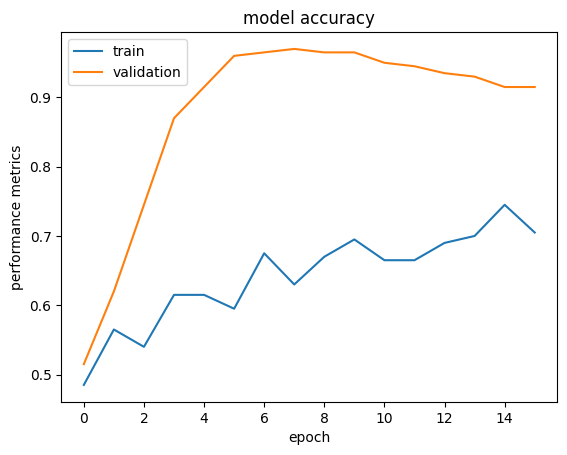

Epoch 1/16


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/7 [===>..........................] - ETA: 10s - loss: 0.8877 - binary_accuracy: 0.3750 - recall_m: 0.3333 - precision_m: 0.0526 - f1_m: 0.0909

7/7 [==============================] - 2s 92ms/step - loss: 1.0491 - binary_accuracy: 0.4000 - recall_m: 0.1667 - precision_m: 0.0307 - f1_m: 0.0518 - val_loss: 0.6954 - val_binary_accuracy: 0.3950 - val_recall_m: 0.5857 - val_precision_m: 0.0735 - val_f1_m: 0.1275
Epoch 2/16
1/7 [===>..........................] - ETA: 0s - loss: 0.7757 - binary_accuracy: 0.4688 - recall_m: 0.5000 - precision_m: 0.0588 - f1_m: 0.1053

7/7 [==============================] - 0s 20ms/step - loss: 0.6792 - binary_accuracy: 0.5200 - recall_m: 0.7286 - precision_m: 0.1263 - f1_m: 0.2077 - val_loss: 0.7138 - val_binary_accuracy: 0.2000 - val_recall_m: 0.8571 - val_precision_m: 0.0847 - val_f1_m: 0.1516
Epoch 3/16
1/7 [===>..........................] - ETA: 0s - loss: 0.7568 - binary_accuracy: 0.5938 - recall_m: 0.7500 - precision_m: 0.2000 - f1_m: 0.3158

7/7 [==============================] - 0s 18ms/step - loss: 0.6123 - binary_accuracy: 0.5300 - recall_m: 0.7262 - precision_m: 0.1198 - f1_m: 0.2016 - val_loss: 0.7252 - val_binary_accuracy: 0.1100 - val_recall_m: 0.8571 - val_precision_m: 0.0779 - val_f1_m: 0.1404
Epoch 4/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5869 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.2941 - f1_m: 0.4545

7/7 [==============================] - 0s 19ms/step - loss: 0.5780 - binary_accuracy: 0.5650 - recall_m: 0.6143 - precision_m: 0.1341 - f1_m: 0.2160 - val_loss: 0.7308 - val_binary_accuracy: 0.1050 - val_recall_m: 0.8571 - val_precision_m: 0.0775 - val_f1_m: 0.1397
Epoch 5/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4524 - binary_accuracy: 0.5938 - recall_m: 1.0000 - precision_m: 0.0714 - f1_m: 0.1333

7/7 [==============================] - 0s 14ms/step - loss: 0.4863 - binary_accuracy: 0.5900 - recall_m: 0.8095 - precision_m: 0.1513 - f1_m: 0.2441 - val_loss: 0.7358 - val_binary_accuracy: 0.1000 - val_recall_m: 0.8571 - val_precision_m: 0.0769 - val_f1_m: 0.1387
Epoch 6/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5976 - binary_accuracy: 0.5312 - recall_m: 1.0000 - precision_m: 0.1667 - f1_m: 0.2857

7/7 [==============================] - 0s 15ms/step - loss: 0.5286 - binary_accuracy: 0.5650 - recall_m: 0.8571 - precision_m: 0.1653 - f1_m: 0.2729 - val_loss: 0.7386 - val_binary_accuracy: 0.0950 - val_recall_m: 0.8571 - val_precision_m: 0.0768 - val_f1_m: 0.1385
Epoch 7/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5689 - binary_accuracy: 0.5625 - recall_m: 0.7500 - precision_m: 0.1875 - f1_m: 0.3000

7/7 [==============================] - 0s 18ms/step - loss: 0.4671 - binary_accuracy: 0.6200 - recall_m: 0.7500 - precision_m: 0.1475 - f1_m: 0.2409 - val_loss: 0.7442 - val_binary_accuracy: 0.0900 - val_recall_m: 0.8571 - val_precision_m: 0.0766 - val_f1_m: 0.1382
Epoch 8/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3574 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.2000 - f1_m: 0.3333

7/7 [==============================] - 0s 24ms/step - loss: 0.4261 - binary_accuracy: 0.6200 - recall_m: 0.8571 - precision_m: 0.1655 - f1_m: 0.2757 - val_loss: 0.7456 - val_binary_accuracy: 0.0900 - val_recall_m: 0.8571 - val_precision_m: 0.0766 - val_f1_m: 0.1382
Epoch 9/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3455 - binary_accuracy: 0.7188 - recall_m: 1.0000 - precision_m: 0.3077 - f1_m: 0.4706

7/7 [==============================] - 0s 26ms/step - loss: 0.4495 - binary_accuracy: 0.6300 - recall_m: 0.8571 - precision_m: 0.2511 - f1_m: 0.3551 - val_loss: 0.7462 - val_binary_accuracy: 0.0950 - val_recall_m: 0.8571 - val_precision_m: 0.0768 - val_f1_m: 0.1385
Epoch 10/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3992 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.0769 - f1_m: 0.1429

7/7 [==============================] - 0s 27ms/step - loss: 0.3915 - binary_accuracy: 0.6350 - recall_m: 0.8571 - precision_m: 0.1642 - f1_m: 0.2650 - val_loss: 0.7482 - val_binary_accuracy: 0.0950 - val_recall_m: 0.8571 - val_precision_m: 0.0768 - val_f1_m: 0.1385
Epoch 11/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3051 - binary_accuracy: 0.7500 - recall_m: 1.0000 - precision_m: 0.3846 - f1_m: 0.5556

7/7 [==============================] - 0s 25ms/step - loss: 0.4001 - binary_accuracy: 0.6600 - recall_m: 1.0000 - precision_m: 0.2577 - f1_m: 0.3777 - val_loss: 0.7474 - val_binary_accuracy: 0.0950 - val_recall_m: 0.8571 - val_precision_m: 0.0768 - val_f1_m: 0.1385
Epoch 12/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3988 - binary_accuracy: 0.5625 - recall_m: 1.0000 - precision_m: 0.1765 - f1_m: 0.3000

7/7 [==============================] - 0s 16ms/step - loss: 0.4156 - binary_accuracy: 0.6300 - recall_m: 1.0000 - precision_m: 0.2097 - f1_m: 0.3357 - val_loss: 0.7403 - val_binary_accuracy: 0.1100 - val_recall_m: 0.8571 - val_precision_m: 0.0773 - val_f1_m: 0.1394
Epoch 13/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3742 - binary_accuracy: 0.6875 - recall_m: 1.0000 - precision_m: 0.1667 - f1_m: 0.2857

7/7 [==============================] - 0s 28ms/step - loss: 0.3801 - binary_accuracy: 0.6750 - recall_m: 0.8571 - precision_m: 0.1915 - f1_m: 0.3093 - val_loss: 0.7377 - val_binary_accuracy: 0.1300 - val_recall_m: 0.8571 - val_precision_m: 0.0791 - val_f1_m: 0.1423
Epoch 14/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3758 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.1429 - f1_m: 0.2500

7/7 [==============================] - 0s 22ms/step - loss: 0.4060 - binary_accuracy: 0.6400 - recall_m: 0.8286 - precision_m: 0.1640 - f1_m: 0.2662 - val_loss: 0.7340 - val_binary_accuracy: 0.1500 - val_recall_m: 0.8571 - val_precision_m: 0.0814 - val_f1_m: 0.1459
Epoch 15/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4080 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.1429 - f1_m: 0.2500

7/7 [==============================] - 0s 19ms/step - loss: 0.3886 - binary_accuracy: 0.6750 - recall_m: 0.8571 - precision_m: 0.1886 - f1_m: 0.2875 - val_loss: 0.7283 - val_binary_accuracy: 0.1750 - val_recall_m: 0.8571 - val_precision_m: 0.0837 - val_f1_m: 0.1497
Epoch 16/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3772 - binary_accuracy: 0.5312 - recall_m: 1.0000 - precision_m: 0.0625 - f1_m: 0.1176

7/7 [==============================] - 0s 4ms/step - loss: 0.7223 - binary_accuracy: 0.2350 - recall_m: 0.8571 - precision_m: 0.0915 - f1_m: 0.1615
Train Accuracy
7/7 [==============================] - 0s 4ms/step - loss: 0.7223 - binary_accuracy: 0.2350 - recall_m: 0.8571 - precision_m: 0.0915 - f1_m: 0.1615
Test Accuracy
7/7 [==============================] - 0s 5ms/step - loss: 0.7223 - binary_accuracy: 0.2350 - recall_m: 0.8571 - precision_m: 0.0915 - f1_m: 0.1615


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Current date: 2022-03-04 (10/12)


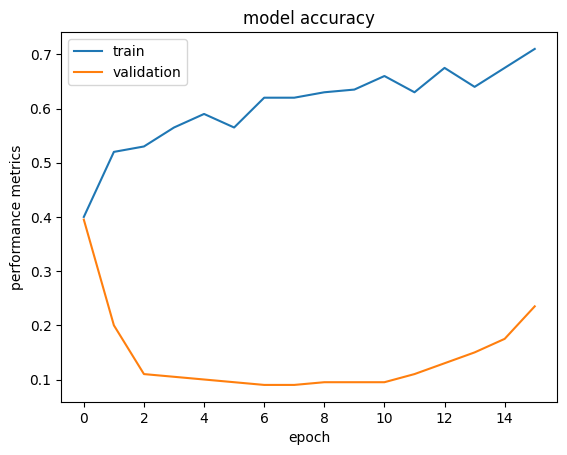

Epoch 1/16


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/7 [===>..........................] - ETA: 10s - loss: 0.6793 - binary_accuracy: 0.4688 - recall_m: 0.5000 - precision_m: 0.0588 - f1_m: 0.1053

7/7 [==============================] - 2s 62ms/step - loss: 0.8849 - binary_accuracy: 0.4750 - recall_m: 0.3810 - precision_m: 0.0578 - f1_m: 0.0999 - val_loss: 0.6763 - val_binary_accuracy: 0.7800 - val_recall_m: 0.4405 - val_precision_m: 0.1752 - val_f1_m: 0.2319
Epoch 2/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4678 - binary_accuracy: 0.5625 - recall_m: 1.0000 - precision_m: 0.1250 - f1_m: 0.2222

7/7 [==============================] - 0s 13ms/step - loss: 0.6575 - binary_accuracy: 0.5600 - recall_m: 0.6190 - precision_m: 0.1237 - f1_m: 0.2037 - val_loss: 0.6642 - val_binary_accuracy: 0.9000 - val_recall_m: 0.4881 - val_precision_m: 0.4048 - val_f1_m: 0.3929
Epoch 3/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5401 - binary_accuracy: 0.5000 - recall_m: 1.0000 - precision_m: 0.0588 - f1_m: 0.1111

7/7 [==============================] - 0s 13ms/step - loss: 0.6353 - binary_accuracy: 0.5850 - recall_m: 0.8214 - precision_m: 0.1917 - f1_m: 0.2898 - val_loss: 0.6525 - val_binary_accuracy: 0.9300 - val_recall_m: 0.5238 - val_precision_m: 0.4905 - val_f1_m: 0.4834
Epoch 4/16
1/7 [===>..........................] - ETA: 0s - loss: 0.7025 - binary_accuracy: 0.5625 - recall_m: 0.5000 - precision_m: 0.1429 - f1_m: 0.2222

7/7 [==============================] - 0s 14ms/step - loss: 0.4927 - binary_accuracy: 0.6300 - recall_m: 0.8571 - precision_m: 0.2094 - f1_m: 0.3241 - val_loss: 0.6387 - val_binary_accuracy: 0.9450 - val_recall_m: 0.4643 - val_precision_m: 0.6429 - val_f1_m: 0.5190
Epoch 5/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4292 - binary_accuracy: 0.6875 - recall_m: 1.0000 - precision_m: 0.1667 - f1_m: 0.2857

7/7 [==============================] - 0s 16ms/step - loss: 0.4520 - binary_accuracy: 0.6450 - recall_m: 0.9524 - precision_m: 0.1994 - f1_m: 0.3239 - val_loss: 0.6240 - val_binary_accuracy: 0.9450 - val_recall_m: 0.4286 - val_precision_m: 0.5714 - val_f1_m: 0.4714
Epoch 6/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4623 - binary_accuracy: 0.5625 - recall_m: 1.0000 - precision_m: 0.1765 - f1_m: 0.3000

7/7 [==============================] - 0s 19ms/step - loss: 0.5055 - binary_accuracy: 0.6150 - recall_m: 0.9286 - precision_m: 0.1990 - f1_m: 0.3177 - val_loss: 0.6101 - val_binary_accuracy: 0.9300 - val_recall_m: 0.1905 - val_precision_m: 0.4286 - val_f1_m: 0.2503
Epoch 7/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4487 - binary_accuracy: 0.6562 - recall_m: 0.8000 - precision_m: 0.2857 - f1_m: 0.4211

7/7 [==============================] - 0s 13ms/step - loss: 0.4884 - binary_accuracy: 0.6400 - recall_m: 0.7571 - precision_m: 0.2843 - f1_m: 0.3675 - val_loss: 0.5960 - val_binary_accuracy: 0.9150 - val_recall_m: 0.0476 - val_precision_m: 0.1429 - val_f1_m: 0.0714
Epoch 8/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3658 - binary_accuracy: 0.7500 - recall_m: 1.0000 - precision_m: 0.2727 - f1_m: 0.4286

7/7 [==============================] - 0s 13ms/step - loss: 0.3961 - binary_accuracy: 0.7100 - recall_m: 1.0000 - precision_m: 0.3495 - f1_m: 0.4569 - val_loss: 0.5819 - val_binary_accuracy: 0.9150 - val_recall_m: 0.0476 - val_precision_m: 0.1429 - val_f1_m: 0.0714
Epoch 9/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5277 - binary_accuracy: 0.6875 - recall_m: 1.0000 - precision_m: 0.3750 - f1_m: 0.5455

7/7 [==============================] - 0s 13ms/step - loss: 0.4337 - binary_accuracy: 0.6900 - recall_m: 0.8095 - precision_m: 0.1918 - f1_m: 0.3014 - val_loss: 0.5707 - val_binary_accuracy: 0.9100 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 10/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4502 - binary_accuracy: 0.7500 - recall_m: 1.0000 - precision_m: 0.4286 - f1_m: 0.6000

7/7 [==============================] - 0s 14ms/step - loss: 0.3816 - binary_accuracy: 0.6850 - recall_m: 1.0000 - precision_m: 0.2248 - f1_m: 0.3563 - val_loss: 0.5598 - val_binary_accuracy: 0.9100 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 11/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4401 - binary_accuracy: 0.6250 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00

7/7 [==============================] - 0s 14ms/step - loss: 0.4031 - binary_accuracy: 0.6800 - recall_m: 0.6667 - precision_m: 0.1858 - f1_m: 0.2863 - val_loss: 0.5467 - val_binary_accuracy: 0.9100 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 12/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4231 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.2143 - f1_m: 0.3529

7/7 [==============================] - 0s 14ms/step - loss: 0.3425 - binary_accuracy: 0.7400 - recall_m: 1.0000 - precision_m: 0.3405 - f1_m: 0.4707 - val_loss: 0.5341 - val_binary_accuracy: 0.9100 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 13/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3114 - binary_accuracy: 0.7812 - recall_m: 1.0000 - precision_m: 0.2222 - f1_m: 0.3636

7/7 [==============================] - 0s 13ms/step - loss: 0.3732 - binary_accuracy: 0.7000 - recall_m: 0.8571 - precision_m: 0.3523 - f1_m: 0.4318 - val_loss: 0.5228 - val_binary_accuracy: 0.9100 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 14/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3234 - binary_accuracy: 0.8750 - recall_m: 1.0000 - precision_m: 0.5556 - f1_m: 0.7143

7/7 [==============================] - 0s 13ms/step - loss: 0.3488 - binary_accuracy: 0.7200 - recall_m: 0.7143 - precision_m: 0.2407 - f1_m: 0.3437 - val_loss: 0.5122 - val_binary_accuracy: 0.9100 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 15/16
1/7 [===>..........................] - ETA: 0s - loss: 0.2880 - binary_accuracy: 0.8125 - recall_m: 1.0000 - precision_m: 0.3333 - f1_m: 0.5000

7/7 [==============================] - 0s 16ms/step - loss: 0.3147 - binary_accuracy: 0.7500 - recall_m: 0.8571 - precision_m: 0.2597 - f1_m: 0.3766 - val_loss: 0.5023 - val_binary_accuracy: 0.9100 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 16/16
1/7 [===>..........................] - ETA: 0s - loss: 0.2279 - binary_accuracy: 0.9062 - recall_m: 1.0000 - precision_m: 0.5714 - f1_m: 0.7273

7/7 [==============================] - 0s 4ms/step - loss: 0.4900 - binary_accuracy: 0.9100 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00
Train Accuracy
7/7 [==============================] - 0s 4ms/step - loss: 0.4900 - binary_accuracy: 0.9100 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00
Test Accuracy
7/7 [==============================] - 0s 3ms/step - loss: 0.4900 - binary_accuracy: 0.9100 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Current date: 2022-03-05 (11/12)


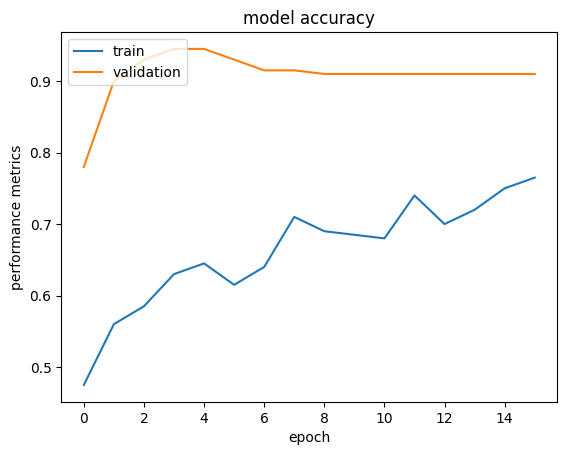

Epoch 1/16


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/7 [===>..........................] - ETA: 13s - loss: 1.5464 - binary_accuracy: 0.4375 - recall_m: 0.4000 - precision_m: 0.1176 - f1_m: 0.1818

7/7 [==============================] - 3s 66ms/step - loss: 1.2863 - binary_accuracy: 0.4750 - recall_m: 0.4381 - precision_m: 0.0903 - f1_m: 0.1484 - val_loss: 0.6964 - val_binary_accuracy: 0.4400 - val_recall_m: 0.7976 - val_precision_m: 0.1366 - val_f1_m: 0.2237
Epoch 2/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5357 - binary_accuracy: 0.4375 - recall_m: 1.0000 - precision_m: 0.0526 - f1_m: 0.1000

7/7 [==============================] - 0s 13ms/step - loss: 0.7509 - binary_accuracy: 0.5800 - recall_m: 0.6810 - precision_m: 0.2003 - f1_m: 0.2939 - val_loss: 0.6944 - val_binary_accuracy: 0.4450 - val_recall_m: 0.8214 - val_precision_m: 0.1432 - val_f1_m: 0.2338
Epoch 3/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4991 - binary_accuracy: 0.6562 - recall_m: 1.0000 - precision_m: 0.2143 - f1_m: 0.3529

7/7 [==============================] - 0s 13ms/step - loss: 0.6496 - binary_accuracy: 0.5900 - recall_m: 0.7810 - precision_m: 0.1763 - f1_m: 0.2790 - val_loss: 0.6882 - val_binary_accuracy: 0.4800 - val_recall_m: 0.8571 - val_precision_m: 0.1524 - val_f1_m: 0.2489
Epoch 4/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4159 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.2941 - f1_m: 0.4545

7/7 [==============================] - 0s 14ms/step - loss: 0.5704 - binary_accuracy: 0.6400 - recall_m: 0.9524 - precision_m: 0.2302 - f1_m: 0.3551 - val_loss: 0.6747 - val_binary_accuracy: 0.6200 - val_recall_m: 0.8571 - val_precision_m: 0.1971 - val_f1_m: 0.3060
Epoch 5/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5677 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.2941 - f1_m: 0.4545

7/7 [==============================] - 0s 14ms/step - loss: 0.5394 - binary_accuracy: 0.5750 - recall_m: 0.8571 - precision_m: 0.1832 - f1_m: 0.2884 - val_loss: 0.6629 - val_binary_accuracy: 0.7500 - val_recall_m: 0.8571 - val_precision_m: 0.2638 - val_f1_m: 0.3842
Epoch 6/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4895 - binary_accuracy: 0.5312 - recall_m: 1.0000 - precision_m: 0.1176 - f1_m: 0.2105

7/7 [==============================] - 0s 13ms/step - loss: 0.4692 - binary_accuracy: 0.6250 - recall_m: 0.9286 - precision_m: 0.2387 - f1_m: 0.3662 - val_loss: 0.6510 - val_binary_accuracy: 0.8150 - val_recall_m: 0.8571 - val_precision_m: 0.3310 - val_f1_m: 0.4492
Epoch 7/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4697 - binary_accuracy: 0.7812 - recall_m: 1.0000 - precision_m: 0.4615 - f1_m: 0.6316

7/7 [==============================] - 0s 15ms/step - loss: 0.4754 - binary_accuracy: 0.6150 - recall_m: 1.0000 - precision_m: 0.2381 - f1_m: 0.3677 - val_loss: 0.6425 - val_binary_accuracy: 0.8800 - val_recall_m: 0.8571 - val_precision_m: 0.4218 - val_f1_m: 0.5321
Epoch 8/16
1/7 [===>..........................] - ETA: 0s - loss: 0.4253 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.2941 - f1_m: 0.4545

7/7 [==============================] - 0s 13ms/step - loss: 0.4152 - binary_accuracy: 0.6850 - recall_m: 0.8095 - precision_m: 0.2081 - f1_m: 0.3150 - val_loss: 0.6324 - val_binary_accuracy: 0.9300 - val_recall_m: 0.8571 - val_precision_m: 0.5401 - val_f1_m: 0.6321
Epoch 9/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3984 - binary_accuracy: 0.6875 - recall_m: 1.0000 - precision_m: 0.2308 - f1_m: 0.3750

7/7 [==============================] - 0s 14ms/step - loss: 0.3638 - binary_accuracy: 0.6900 - recall_m: 1.0000 - precision_m: 0.2791 - f1_m: 0.4269 - val_loss: 0.6216 - val_binary_accuracy: 0.9600 - val_recall_m: 0.8571 - val_precision_m: 0.6024 - val_f1_m: 0.6888
Epoch 10/16
1/7 [===>..........................] - ETA: 0s - loss: 0.2673 - binary_accuracy: 0.7812 - recall_m: 1.0000 - precision_m: 0.3000 - f1_m: 0.4615

7/7 [==============================] - 0s 13ms/step - loss: 0.3649 - binary_accuracy: 0.6700 - recall_m: 0.8571 - precision_m: 0.2199 - f1_m: 0.3452 - val_loss: 0.6084 - val_binary_accuracy: 0.9850 - val_recall_m: 0.8571 - val_precision_m: 0.7653 - val_f1_m: 0.7985
Epoch 11/16
1/7 [===>..........................] - ETA: 0s - loss: 0.5533 - binary_accuracy: 0.5000 - recall_m: 1.0000 - precision_m: 0.0588 - f1_m: 0.1111

7/7 [==============================] - 0s 14ms/step - loss: 0.4020 - binary_accuracy: 0.6800 - recall_m: 1.0000 - precision_m: 0.3623 - f1_m: 0.4705 - val_loss: 0.5955 - val_binary_accuracy: 0.9950 - val_recall_m: 0.8571 - val_precision_m: 0.8367 - val_f1_m: 0.8462
Epoch 12/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3063 - binary_accuracy: 0.7812 - recall_m: 1.0000 - precision_m: 0.4615 - f1_m: 0.6316

7/7 [==============================] - 0s 16ms/step - loss: 0.3335 - binary_accuracy: 0.7050 - recall_m: 0.8571 - precision_m: 0.2303 - f1_m: 0.3542 - val_loss: 0.5840 - val_binary_accuracy: 0.9950 - val_recall_m: 0.8571 - val_precision_m: 0.8367 - val_f1_m: 0.8462
Epoch 13/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3475 - binary_accuracy: 0.7500 - recall_m: 1.0000 - precision_m: 0.2727 - f1_m: 0.4286

7/7 [==============================] - 0s 14ms/step - loss: 0.3447 - binary_accuracy: 0.7300 - recall_m: 1.0000 - precision_m: 0.2842 - f1_m: 0.4316 - val_loss: 0.5736 - val_binary_accuracy: 0.9950 - val_recall_m: 0.8571 - val_precision_m: 0.8367 - val_f1_m: 0.8462
Epoch 14/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3439 - binary_accuracy: 0.7500 - recall_m: 1.0000 - precision_m: 0.3846 - f1_m: 0.5556

7/7 [==============================] - 0s 15ms/step - loss: 0.3572 - binary_accuracy: 0.7450 - recall_m: 0.7143 - precision_m: 0.2684 - f1_m: 0.3778 - val_loss: 0.5615 - val_binary_accuracy: 0.9950 - val_recall_m: 0.8571 - val_precision_m: 0.8367 - val_f1_m: 0.8462
Epoch 15/16
1/7 [===>..........................] - ETA: 0s - loss: 0.3932 - binary_accuracy: 0.6250 - recall_m: 1.0000 - precision_m: 0.2000 - f1_m: 0.3333

7/7 [==============================] - 0s 14ms/step - loss: 0.2902 - binary_accuracy: 0.7300 - recall_m: 1.0000 - precision_m: 0.2977 - f1_m: 0.4461 - val_loss: 0.5503 - val_binary_accuracy: 1.0000 - val_recall_m: 0.8571 - val_precision_m: 0.8571 - val_f1_m: 0.8571
Epoch 16/16
1/7 [===>..........................] - ETA: 0s - loss: 0.2312 - binary_accuracy: 0.7500 - recall_m: 1.0000 - precision_m: 0.3333 - f1_m: 0.5000

7/7 [==============================] - 0s 5ms/step - loss: 0.5402 - binary_accuracy: 0.9950 - recall_m: 0.8214 - precision_m: 0.8571 - f1_m: 0.8367
Train Accuracy
7/7 [==============================] - 0s 4ms/step - loss: 0.5402 - binary_accuracy: 0.9950 - recall_m: 0.8214 - precision_m: 0.8571 - f1_m: 0.8367
Test Accuracy
7/7 [==============================] - 0s 4ms/step - loss: 0.5402 - binary_accuracy: 0.9950 - recall_m: 0.8214 - precision_m: 0.8571 - f1_m: 0.8367


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Current date: 2022-03-06 (12/12)


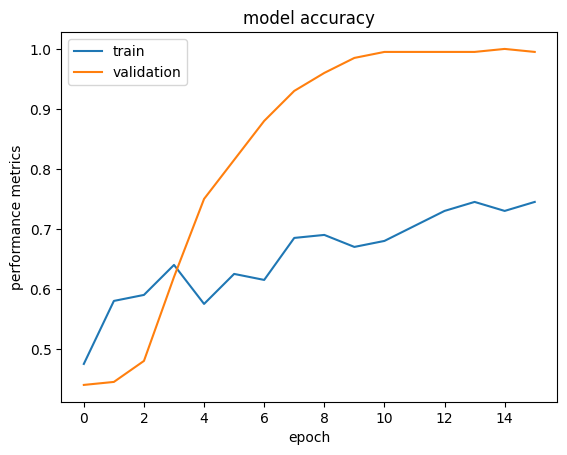

In [32]:

# Dict with all the labelled elements, every iteration it is filled with #{BUDGET} more labelled elements
labelled_elements = {}

x, y = [], []

metrics = {"binary_accuracy":[],
           "val_binary_accuracy":[]
           "recall_m":[],
           "precision_m":[],
           "f1_m":[],}

for date in pd.date_range(min_date, max_date - pd.Timedelta(days=1)):
  curr = df[df.ts.dt.date == date.date()]
  next = df[df.ts.dt.date == (date + pd.Timedelta(days=1)).date()]


  # ACTIVE LEARNING PART: selecting which elements to use for training
  if AL_EFFICIENCY == "optimal":
    x.append(curr["embedding"])
    y.append(curr[LABEL])
  elif AL_EFFICIENCY == "normal":
    labelled_elements = al_methods[AL_METHOD](curr, labelled_elements, BUDGET, LABEL)
    x, y = list(labelled_elements.keys()), list(labelled_elements.values())
  elif AL_EFFICIENCY == "forgetful":
    labelled_elements = al_methods[AL_METHOD](curr, {}, BUDGET, LABEL)
    x, y = list(labelled_elements.keys()), list(labelled_elements.values())
  else:
      x, y = [], []



  # Getting correct sets
  x_train, y_train, x_test, y_test, x_val, y_val = get_network_sets(x, y, next)

  # Creating model
  model, callback = create_model()

  # Calculating weights for better cnn performance
  class_weights = compute_class_weight(class_weight='balanced', classes=list(set(y)), y=y)
  class_weights = {class_index: weight for class_index, weight in enumerate(class_weights)}

  # Training model
  history = model.fit(x_train, y_train,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      verbose=1,
                      validation_data=([x_val, y_val]),
                      callbacks=callback,
                      class_weight=class_weights)

  # Evaluating Model
  model.evaluate(x_test, y_test, verbose=1)

  print('Train Accuracy')
  model.evaluate(x_train, y_train)
  print('Test Accuracy')
  model.evaluate(x_test, y_test)
  for i in metrics.keys():
    metrics[i].append(history.history[i][-1])

  save_model(model)

  print(f"Current date: {date.date()} ({(pd.to_datetime(date) - pd.to_datetime(min_date)).days}/{((max_date - min_date).days - 1)})")
  plot_results(history)


### Examples

In [34]:

examples = {"Ukraine's struggle: Lives lost, infrastructure shattered, and a haunting echo of war's relentless toll" : 1.0,
            "Immaculate bundles of joy, frolicking furballs with hearts full of love – that's the adorable charm of cute puppies" : 0.0,
            "Another day, another loss. Dionisi has to leave if Sassuolo wants to stay in Serie A #DionisiOUT #Empoli-Sassuolo #6-1" : 0.0,
            "Inter Milano has defeated Dynamo Kiev once again! ⚽️🔵⚫️ #InterMilan #ChampionsLeague" : 0.0,
            "Thoughts with Palestine during this difficult time, may the souls of the departed find tranquility in the afterlife 🕊️💔 #EternalPeace" : 1.0,
}

for text_example, label in examples.items():

  encoded_text = [embed_text(text_example)]
  encoded_text = np.array(encoded_text)

  output = model.predict(encoded_text)[0][0]

  print(f"Text: {text_example}\nDesired output: {decision(label)}\nActual output: {decision(output)} ({output})")


1/1 [==============================] - 0s 147ms/step
Text: Ukraine's struggle: Lives lost, infrastructure shattered, and a haunting echo of war's relentless toll
Desired output: True
Actual output: False (0.46897515654563904)
1/1 [==============================] - 0s 23ms/step
Text: Immaculate bundles of joy, frolicking furballs with hearts full of love – that's the adorable charm of cute puppies
Desired output: False
Actual output: False (0.42044156789779663)
1/1 [==============================] - 0s 29ms/step
Text: Another day, another loss. Dionisi has to leave if Sassuolo wants to stay in Serie A #DionisiOUT #Empoli-Sassuolo #6-1
Desired output: False
Actual output: False (0.4076709449291229)
1/1 [==============================] - 0s 25ms/step
Text: Inter Milano has defeated Dynamo Kiev once again! ⚽️🔵⚫️ #InterMilan #ChampionsLeague
Desired output: False
Actual output: False (0.4185558557510376)
1/1 [==============================] - 0s 25ms/step
Text: Thoughts with Palestine durin

In [35]:
# @title Try it out!

TWEET = "Ukraine's struggle: Lives lost, infrastructure shattered, and a haunting echo of war's relentless toll" # @param {type:"string"}
EXPECTED_RESULT = True # @param {type:"boolean"}
encoded_text = [embed_text(TWEET)]
encoded_text = np.array(encoded_text)

output = model.predict(encoded_text)[0][0]

print(f"Text: {TWEET}\nDesired output: {decision(EXPECTED_RESULT)}\nActual output: {decision(output)} ({output})")


1/1 [==============================] - 0s 24ms/step
Text: Ukraine's struggle: Lives lost, infrastructure shattered, and a haunting echo of war's relentless toll
Desired output: False
Actual output: False (0.46897515654563904)


In [36]:
save_model(model, title=NAME, metrics=metrics)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
